In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.layers import Dense, InputLayer, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import recall_score, make_scorer, roc_auc_score, accuracy_score, plot_roc_curve, f1_score, precision_score, confusion_matrix
sns.set_style("whitegrid")
sns.set_palette("Paired")

In [2]:
#open data set
df = pd.read_csv('../data/heart.csv')
#sum nan values
print(df.isna().sum())
print(df.dtypes)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


/home/vladimir/Desktop/Heart-Disease/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


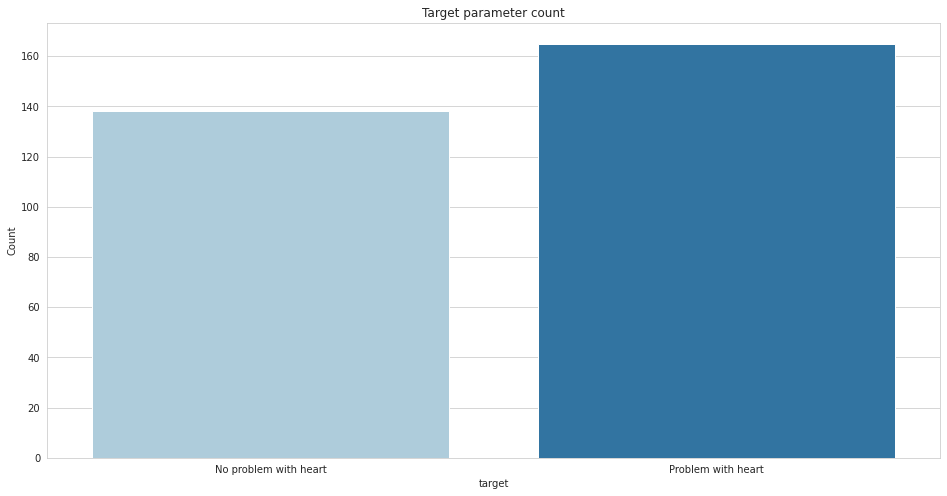

In [3]:
#show target count
plt.figure(figsize=(16, 8))
sns.countplot('target', data=df)
plt.xticks(ticks = [0, 1],labels=('No problem with heart', 'Problem with heart'))
plt.ylabel('Count')
plt.title('Target parameter count')
plt.show()

In [4]:
df['exang'] = df['exang'].apply(lambda x: 'yes' if x == 1 else 'no')
df['cp'] = df['cp'].apply(lambda x: 'typical_angina' if x == 1 else
                          'atypical_angina' if x == 2 else
                          'non_anginal_pain' if x == 3 else
                          'asymptomatic')
df['fbs'] = df['fbs'].apply(lambda x: 'lower_than_120mg/ml' if x == 0 else 'higher_than_120mg/ml')
df['restecg'] = df['restecg'].apply(lambda x: 'normal' if x == 0 else
                                    'st_t_wave abnormality' if x == 1 else
                                    'left_ventricular_hypertrophy')
df['sex'] = df['sex'].apply(lambda x: 'male' if x == 1 else 'female')
df['slope'] = df['slope'].apply(lambda x: 'upsloping' if x == 0 else 'flat' if x == 1 else 'downsloping')
df['thal'] = df['thal'].apply(lambda x: 'normal' if x == 1 else 'fixed_defect' if x == 2 else 'reversable_defect')

In [5]:
x = df.drop('target', axis=1)
y = df['target']
x = pd.get_dummies(x)
ct = ColumnTransformer([('scaled', StandardScaler(), x.select_dtypes(include=['int64', 'float64']).columns)],
                       remainder='passthrough')

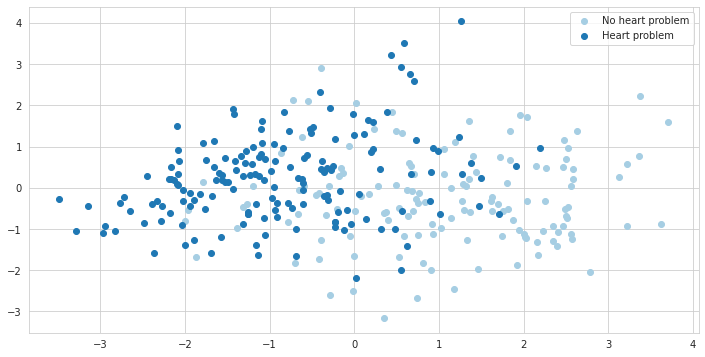

In [6]:
#show dataset
pca = PCA(n_components=2)
x_pca = pca.fit_transform(ct.fit_transform(x))
df_pca = pd.DataFrame(data=x_pca, columns=['1 component', '2 component'])
df_pca['target'] = y
df_pca_heart_problem = df_pca[df_pca['target'] == 1]
df_pca_no_heart_problem = df_pca[df_pca['target'] == 0]
plt.figure(figsize=(12, 6))
plt.scatter(df_pca_no_heart_problem.iloc[:, 0], df_pca_no_heart_problem.iloc[:, 1], label='No heart problem')
plt.scatter(df_pca_heart_problem.iloc[:, 0], df_pca_heart_problem.iloc[:, 1], label='Heart problem')
plt.legend()
plt.show()

In [7]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test)
print(x.shape, x_train_scaled.shape)

(303, 25) (242, 25)


In [8]:
def keras_model(lr, neurons):
    model=Sequential()
    model.add(InputLayer(input_shape=(x.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=keras_model, epochs=20)

In [9]:
pd.set_option('display.max_rows', 100000)
params = dict(batch_size=[32, 64, 128], lr= [0.000001, 0.0001, 0.001, 0.01, 0.1,],
             neurons=[8, 16, 32, 64, 128, 256, 512])
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
grid = GridSearchCV(model, params, return_train_score=True, scoring=make_scorer(roc_auc_score))
grid.fit(x_train_scaled, y_train, callbacks=[es], validation_data=(x_test_scaled, y_test))
grid_result = pd.DataFrame(grid.cv_results_)

Epoch 1/20
7/7 [==============================] - 0s 14ms/step - loss: 0.7844 - acc: 0.3782 - val_loss: 0.7602 - val_acc: 0.4262
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7844 - acc: 0.3782 - val_loss: 0.7602 - val_acc: 0.4262
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.7844 - acc: 0.3782 - val_loss: 0.7602 - val_acc: 0.4262
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7844 - acc: 0.3782 - val_loss: 0.7602 - val_acc: 0.4262
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.7843 - acc: 0.3782 - val_loss: 0.7602 - val_acc: 0.4262
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.7843 - acc: 0.3782 - val_loss: 0.7601 - val_acc: 0.4262
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7843 - acc: 0.3782 - val_loss: 0.7601 - val_acc: 0.4262
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7843 - acc: 0.3782 - val_loss: 

Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6667 - acc: 0.6289 - val_loss: 0.7009 - val_acc: 0.5574
Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.9558 - acc: 0.3351 - val_loss: 0.9681 - val_acc: 0.3115
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9558 - acc: 0.3351 - val_loss: 0.9681 - val_acc: 0.3115
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9557 - acc: 0.3351 - val_loss: 0.9680 - val_acc: 0.3115
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9557 - acc: 0.3351 - val_loss: 0.9680 - val_acc: 0.3115
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9556 - acc: 0.3351 - val_loss: 0.9679 - val_acc: 0.3115
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9556 - acc: 0.3351 - val_loss: 0.9679 - val_acc: 0.3115
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9555 - acc: 0.3351 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7538 - acc: 0.4560 - val_loss: 0.7529 - val_acc: 0.4590
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7538 - acc: 0.4560 - val_loss: 0.7528 - val_acc: 0.4590
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7538 - acc: 0.4560 - val_loss: 0.7528 - val_acc: 0.4590
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7537 - acc: 0.4560 - val_loss: 0.7528 - val_acc: 0.4590
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7537 - acc: 0.4560 - val_loss: 0.7528 - val_acc: 0.4590
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7537 - acc: 0.4560 - val_loss: 0.7528 - val_acc: 0.4590
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7536 - acc: 0.4560 - val_loss: 0.7527 - val_acc: 0.4590
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7536 - acc: 0.4560 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6305 - acc: 0.6340 - val_loss: 0.6049 - val_acc: 0.7049
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6305 - acc: 0.6340 - val_loss: 0.6049 - val_acc: 0.7049
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - acc: 0.6340 - val_loss: 0.6049 - val_acc: 0.7049
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - acc: 0.6340 - val_loss: 0.6048 - val_acc: 0.7049
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - acc: 0.6340 - val_loss: 0.6048 - val_acc: 0.7049
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6304 - acc: 0.6340 - val_loss: 0.6048 - val_acc: 0.7049
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6303 - acc: 0.6340 - val_loss: 0.6048 - val_acc: 0.7049
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6303 - acc: 0.6340 - val_l

Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6746 - acc: 0.5258 - val_loss: 0.7003 - val_acc: 0.4754
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6746 - acc: 0.5258 - val_loss: 0.7003 - val_acc: 0.4754
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6745 - acc: 0.5258 - val_loss: 0.7002 - val_acc: 0.4754
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6745 - acc: 0.5258 - val_loss: 0.7002 - val_acc: 0.4754
Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6745 - acc: 0.5258 - val_loss: 0.7002 - val_acc: 0.4754
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6745 - acc: 0.5258 - val_loss: 0.7002 - val_acc: 0.4754
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6745 - acc: 0.5258 - val_loss: 0.7001 - val_acc: 0.4754
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6744 - acc: 0.5258 - val

Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7305 - acc: 0.4870 - val_loss: 0.7457 - val_acc: 0.5082
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7305 - acc: 0.4870 - val_loss: 0.7457 - val_acc: 0.5082
Epoch 18/20
7/7 [==============================] - 0s 4ms/step - loss: 0.7304 - acc: 0.4870 - val_loss: 0.7456 - val_acc: 0.5082
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7304 - acc: 0.4870 - val_loss: 0.7455 - val_acc: 0.5082
Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7303 - acc: 0.4870 - val_loss: 0.7455 - val_acc: 0.5082
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.6377 - acc: 0.6010 - val_loss: 0.6630 - val_acc: 0.5738
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6376 - acc: 0.6010 - val_loss: 0.6629 - val_acc: 0.5738
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6375 - acc: 0.6010 - val_l

Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8272 - acc: 0.2629 - val_loss: 0.8477 - val_acc: 0.2951
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7852 - acc: 0.4639 - val_loss: 0.7215 - val_acc: 0.4754
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7851 - acc: 0.4639 - val_loss: 0.7214 - val_acc: 0.4754
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7850 - acc: 0.4639 - val_loss: 0.7213 - val_acc: 0.4754
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7849 - acc: 0.4639 - val_loss: 0.7212 - val_acc: 0.4754
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7848 - acc: 0.4639 - val_loss: 0.7211 - val_acc: 0.4754
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7847 - acc: 0.4639 - val_loss: 0.7210 - val_acc: 0.4754
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7846 - acc: 0.4639 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7333 - acc: 0.3763 - val_loss: 0.7520 - val_acc: 0.3770
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7332 - acc: 0.3763 - val_loss: 0.7519 - val_acc: 0.3770
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7331 - acc: 0.3763 - val_loss: 0.7518 - val_acc: 0.3770
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7330 - acc: 0.3763 - val_loss: 0.7517 - val_acc: 0.3770
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7329 - acc: 0.3763 - val_loss: 0.7515 - val_acc: 0.3770
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7328 - acc: 0.3763 - val_loss: 0.7514 - val_acc: 0.3770
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7327 - acc: 0.3763 - val_loss: 0.7513 - val_acc: 0.3770
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7326 - acc: 0.3763 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6371 - acc: 0.7409 - val_loss: 0.6325 - val_acc: 0.7705
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6370 - acc: 0.7461 - val_loss: 0.6324 - val_acc: 0.7705
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6369 - acc: 0.7461 - val_loss: 0.6323 - val_acc: 0.7705
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6368 - acc: 0.7461 - val_loss: 0.6322 - val_acc: 0.7705
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6367 - acc: 0.7461 - val_loss: 0.6321 - val_acc: 0.7705
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6366 - acc: 0.7513 - val_loss: 0.6320 - val_acc: 0.7705
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6366 - acc: 0.7513 - val_loss: 0.6319 - val_acc: 0.7705
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6365 - acc: 0.7513 - val_l

Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6728 - acc: 0.5567 - val_loss: 0.6703 - val_acc: 0.5738
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6727 - acc: 0.5567 - val_loss: 0.6702 - val_acc: 0.5738
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6726 - acc: 0.5567 - val_loss: 0.6701 - val_acc: 0.5738
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6725 - acc: 0.5567 - val_loss: 0.6700 - val_acc: 0.5738
Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6724 - acc: 0.5567 - val_loss: 0.6699 - val_acc: 0.5738
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6723 - acc: 0.5567 - val_loss: 0.6698 - val_acc: 0.5738
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6722 - acc: 0.5567 - val_loss: 0.6697 - val_acc: 0.5738
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6721 - acc: 0.5567 - val

Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7087 - acc: 0.4663 - val_loss: 0.7051 - val_acc: 0.4754
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7086 - acc: 0.4663 - val_loss: 0.7050 - val_acc: 0.4754
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7084 - acc: 0.4663 - val_loss: 0.7048 - val_acc: 0.4754
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7082 - acc: 0.4663 - val_loss: 0.7047 - val_acc: 0.4754
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7081 - acc: 0.4663 - val_loss: 0.7045 - val_acc: 0.4754
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7364 - acc: 0.4072 - val_loss: 0.7367 - val_acc: 0.4262
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7361 - acc: 0.4072 - val_loss: 0.7365 - val_acc: 0.4262
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7359 - acc: 0.4072 - val_l

Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6700 - acc: 0.5670 - val_loss: 0.6756 - val_acc: 0.5738
Epoch 1/20
7/7 [==============================] - 0s 30ms/step - loss: 0.8468 - acc: 0.3472 - val_loss: 0.8244 - val_acc: 0.2951
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8446 - acc: 0.3472 - val_loss: 0.8225 - val_acc: 0.2951
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8428 - acc: 0.3472 - val_loss: 0.8207 - val_acc: 0.2951
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8410 - acc: 0.3472 - val_loss: 0.8190 - val_acc: 0.2951
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8392 - acc: 0.3523 - val_loss: 0.8174 - val_acc: 0.2951
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8376 - acc: 0.3523 - val_loss: 0.8158 - val_acc: 0.2951
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8359 - acc: 0.3575 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7271 - acc: 0.5515 - val_loss: 0.7409 - val_acc: 0.5410
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7252 - acc: 0.5515 - val_loss: 0.7381 - val_acc: 0.5410
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7231 - acc: 0.5515 - val_loss: 0.7355 - val_acc: 0.5410
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7212 - acc: 0.5515 - val_loss: 0.7329 - val_acc: 0.5410
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7192 - acc: 0.5515 - val_loss: 0.7305 - val_acc: 0.5410
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7174 - acc: 0.5515 - val_loss: 0.7285 - val_acc: 0.5410
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7160 - acc: 0.5515 - val_loss: 0.7265 - val_acc: 0.5410
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7145 - acc: 0.5515 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7417 - acc: 0.4715 - val_loss: 0.7410 - val_acc: 0.4754
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7399 - acc: 0.4767 - val_loss: 0.7394 - val_acc: 0.4754
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7383 - acc: 0.4767 - val_loss: 0.7376 - val_acc: 0.4754
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7365 - acc: 0.4870 - val_loss: 0.7357 - val_acc: 0.4754
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7348 - acc: 0.4819 - val_loss: 0.7340 - val_acc: 0.4754
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7331 - acc: 0.4870 - val_loss: 0.7322 - val_acc: 0.4918
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7314 - acc: 0.4870 - val_loss: 0.7304 - val_acc: 0.4918
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7297 - acc: 0.4870 - val_l

Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7907 - acc: 0.3505 - val_loss: 0.8103 - val_acc: 0.2623
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7874 - acc: 0.3608 - val_loss: 0.8063 - val_acc: 0.2623
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7840 - acc: 0.3608 - val_loss: 0.8026 - val_acc: 0.2623
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7808 - acc: 0.3660 - val_loss: 0.7990 - val_acc: 0.2787
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7779 - acc: 0.3660 - val_loss: 0.7954 - val_acc: 0.2951
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7748 - acc: 0.3763 - val_loss: 0.7918 - val_acc: 0.2951
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7717 - acc: 0.3814 - val_loss: 0.7878 - val_acc: 0.3115
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7685 - acc: 0.3918 - val

Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5642 - acc: 0.7474 - val_loss: 0.5361 - val_acc: 0.7869
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5623 - acc: 0.7474 - val_loss: 0.5339 - val_acc: 0.8033
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5604 - acc: 0.7474 - val_loss: 0.5320 - val_acc: 0.8033
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5587 - acc: 0.7577 - val_loss: 0.5301 - val_acc: 0.8361
Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5569 - acc: 0.7629 - val_loss: 0.5280 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8060 - acc: 0.5258 - val_loss: 0.7802 - val_acc: 0.5246
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7992 - acc: 0.5309 - val_loss: 0.7723 - val_acc: 0.5410
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7930 - acc: 0.5361 - val_l

Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5700 - acc: 0.7409 - val_loss: 0.5525 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.8399 - acc: 0.2902 - val_loss: 0.8084 - val_acc: 0.3279
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8307 - acc: 0.3109 - val_loss: 0.8002 - val_acc: 0.3443
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8230 - acc: 0.3057 - val_loss: 0.7926 - val_acc: 0.3443
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8158 - acc: 0.3161 - val_loss: 0.7853 - val_acc: 0.3770
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8092 - acc: 0.3264 - val_loss: 0.7783 - val_acc: 0.4262
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8023 - acc: 0.3316 - val_loss: 0.7714 - val_acc: 0.4590
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7960 - acc: 0.3368 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6330 - acc: 0.6753 - val_loss: 0.6189 - val_acc: 0.7213
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6291 - acc: 0.6753 - val_loss: 0.6143 - val_acc: 0.7213
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6250 - acc: 0.6907 - val_loss: 0.6095 - val_acc: 0.7213
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6209 - acc: 0.6959 - val_loss: 0.6050 - val_acc: 0.7213
Epoch 8/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6169 - acc: 0.7010 - val_loss: 0.6003 - val_acc: 0.7377
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6128 - acc: 0.7062 - val_loss: 0.5959 - val_acc: 0.7377
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6091 - acc: 0.7113 - val_loss: 0.5917 - val_acc: 0.7377
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6053 - acc: 0.7113 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6469 - acc: 0.6598 - val_loss: 0.6449 - val_acc: 0.7213
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6396 - acc: 0.6804 - val_loss: 0.6366 - val_acc: 0.7541
Epoch 10/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6323 - acc: 0.6959 - val_loss: 0.6285 - val_acc: 0.7541
Epoch 11/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6255 - acc: 0.7216 - val_loss: 0.6212 - val_acc: 0.7705
Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6190 - acc: 0.7216 - val_loss: 0.6141 - val_acc: 0.7869
Epoch 13/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6125 - acc: 0.7320 - val_loss: 0.6064 - val_acc: 0.7869
Epoch 14/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6061 - acc: 0.7474 - val_loss: 0.5988 - val_acc: 0.8033
Epoch 15/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6000 - acc: 0.7526 - val_l

Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6152 - acc: 0.6684 - val_loss: 0.6043 - val_acc: 0.6885
Epoch 13/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6073 - acc: 0.6684 - val_loss: 0.5953 - val_acc: 0.7049
Epoch 14/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5990 - acc: 0.6839 - val_loss: 0.5876 - val_acc: 0.7049
Epoch 15/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5921 - acc: 0.6995 - val_loss: 0.5799 - val_acc: 0.7049
Epoch 16/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5850 - acc: 0.7047 - val_loss: 0.5721 - val_acc: 0.7049
Epoch 17/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5780 - acc: 0.7150 - val_loss: 0.5638 - val_acc: 0.7541
Epoch 18/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5711 - acc: 0.7202 - val_loss: 0.5566 - val_acc: 0.7541
Epoch 19/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5638 - acc: 0.7513 - val

Epoch 16/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5576 - acc: 0.7887 - val_loss: 0.5186 - val_acc: 0.8689
Epoch 17/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5515 - acc: 0.7938 - val_loss: 0.5110 - val_acc: 0.8689
Epoch 18/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5447 - acc: 0.7938 - val_loss: 0.5038 - val_acc: 0.8689
Epoch 19/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5384 - acc: 0.7938 - val_loss: 0.4963 - val_acc: 0.8689
Epoch 20/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5319 - acc: 0.7887 - val_loss: 0.4892 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.7259 - acc: 0.4278 - val_loss: 0.6788 - val_acc: 0.5082
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.7103 - acc: 0.4639 - val_loss: 0.6660 - val_acc: 0.5574
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6975 - acc: 0.4897 - val_l

Epoch 20/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4894 - acc: 0.8238 - val_loss: 0.4673 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.7011 - acc: 0.5000 - val_loss: 0.6960 - val_acc: 0.5246
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6794 - acc: 0.5773 - val_loss: 0.6725 - val_acc: 0.6230
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6611 - acc: 0.6598 - val_loss: 0.6525 - val_acc: 0.6721
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6443 - acc: 0.6804 - val_loss: 0.6343 - val_acc: 0.7213
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6294 - acc: 0.7010 - val_loss: 0.6169 - val_acc: 0.7869
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6161 - acc: 0.7216 - val_loss: 0.6011 - val_acc: 0.8361
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6035 - acc: 0.7371 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5685 - acc: 0.6839 - val_loss: 0.5417 - val_acc: 0.7541
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5605 - acc: 0.6891 - val_loss: 0.5340 - val_acc: 0.7705
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5516 - acc: 0.6995 - val_loss: 0.5256 - val_acc: 0.7705
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5431 - acc: 0.6995 - val_loss: 0.5173 - val_acc: 0.7705
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5347 - acc: 0.6995 - val_loss: 0.5091 - val_acc: 0.7705
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5271 - acc: 0.7150 - val_loss: 0.5012 - val_acc: 0.7705
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5192 - acc: 0.7358 - val_loss: 0.4945 - val_acc: 0.7869
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5126 - acc: 0.7358 - val_loss:

7/7 [==============================] - 0s 4ms/step - loss: 0.6674 - acc: 0.5979 - val_loss: 0.6191 - val_acc: 0.7049
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6510 - acc: 0.6392 - val_loss: 0.6030 - val_acc: 0.7049
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6372 - acc: 0.6443 - val_loss: 0.5894 - val_acc: 0.7213
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6242 - acc: 0.6649 - val_loss: 0.5747 - val_acc: 0.7377
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6105 - acc: 0.6856 - val_loss: 0.5610 - val_acc: 0.7705
Epoch 12/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5978 - acc: 0.6856 - val_loss: 0.5474 - val_acc: 0.7869
Epoch 13/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5862 - acc: 0.6907 - val_loss: 0.5342 - val_acc: 0.7869
Epoch 14/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5744 - acc: 0.6959 - val_loss: 0.5223 

Epoch 11/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5350 - acc: 0.7565 - val_loss: 0.5076 - val_acc: 0.8361
Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5265 - acc: 0.7617 - val_loss: 0.4979 - val_acc: 0.8525
Epoch 13/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5185 - acc: 0.7720 - val_loss: 0.4891 - val_acc: 0.8525
Epoch 14/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5116 - acc: 0.7720 - val_loss: 0.4812 - val_acc: 0.8525
Epoch 15/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5042 - acc: 0.7772 - val_loss: 0.4731 - val_acc: 0.8525
Epoch 16/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4975 - acc: 0.7772 - val_loss: 0.4654 - val_acc: 0.8525
Epoch 17/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4904 - acc: 0.7824 - val_loss: 0.4584 - val_acc: 0.8525
Epoch 18/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4841 - acc: 0.7876 - val

Epoch 15/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4246 - acc: 0.8247 - val_loss: 0.4009 - val_acc: 0.8525
Epoch 16/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4181 - acc: 0.8299 - val_loss: 0.3927 - val_acc: 0.8689
Epoch 17/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4103 - acc: 0.8351 - val_loss: 0.3861 - val_acc: 0.8689
Epoch 18/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4050 - acc: 0.8351 - val_loss: 0.3795 - val_acc: 0.8852
Epoch 19/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3991 - acc: 0.8351 - val_loss: 0.3756 - val_acc: 0.8689
Epoch 20/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3927 - acc: 0.8402 - val_loss: 0.3718 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6991 - acc: 0.5130 - val_loss: 0.6764 - val_acc: 0.5574
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6528 - acc: 0.5803 - val_

Epoch 19/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3676 - acc: 0.8711 - val_loss: 0.3364 - val_acc: 0.8852
Epoch 20/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3626 - acc: 0.8660 - val_loss: 0.3306 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6726 - acc: 0.5309 - val_loss: 0.6259 - val_acc: 0.6885
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.6372 - acc: 0.6082 - val_loss: 0.5919 - val_acc: 0.7541
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6088 - acc: 0.6546 - val_loss: 0.5634 - val_acc: 0.8197
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5843 - acc: 0.7320 - val_loss: 0.5382 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5634 - acc: 0.7526 - val_loss: 0.5141 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5436 - acc: 0.7629 - val_loss

Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5903 - acc: 0.7254 - val_loss: 0.5460 - val_acc: 0.7705
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5588 - acc: 0.7565 - val_loss: 0.5155 - val_acc: 0.7869
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5340 - acc: 0.7720 - val_loss: 0.4873 - val_acc: 0.8361
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5132 - acc: 0.7824 - val_loss: 0.4603 - val_acc: 0.8361
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4924 - acc: 0.7927 - val_loss: 0.4357 - val_acc: 0.8525
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4734 - acc: 0.8083 - val_loss: 0.4185 - val_acc: 0.8525
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4601 - acc: 0.8135 - val_loss: 0.4085 - val_acc: 0.8852
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4491 - acc: 0.8135 - val_loss: 

Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4868 - acc: 0.8196 - val_loss: 0.4360 - val_acc: 0.8525
Epoch 8/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4695 - acc: 0.8299 - val_loss: 0.4195 - val_acc: 0.8525
Epoch 9/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4552 - acc: 0.8454 - val_loss: 0.4055 - val_acc: 0.8525
Epoch 10/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4434 - acc: 0.8454 - val_loss: 0.3938 - val_acc: 0.8689
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4338 - acc: 0.8402 - val_loss: 0.3828 - val_acc: 0.8689
Epoch 12/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4231 - acc: 0.8505 - val_loss: 0.3745 - val_acc: 0.8689
Epoch 13/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4128 - acc: 0.8608 - val_loss: 0.3686 - val_acc: 0.8689
Epoch 14/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4028 - acc: 0.8557 - val_lo

Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3521 - acc: 0.8557 - val_loss: 0.3390 - val_acc: 0.8852
Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3448 - acc: 0.8557 - val_loss: 0.3384 - val_acc: 0.8852
Epoch 13/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3392 - acc: 0.8608 - val_loss: 0.3369 - val_acc: 0.9016
Epoch 14/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3341 - acc: 0.8711 - val_loss: 0.3413 - val_acc: 0.8852
Epoch 15/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3308 - acc: 0.8660 - val_loss: 0.3449 - val_acc: 0.8852
Epoch 16/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3268 - acc: 0.8608 - val_loss: 0.3413 - val_acc: 0.8852
Epoch 17/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3213 - acc: 0.8660 - val_loss: 0.3351 - val_acc: 0.8852
Epoch 18/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3163 - acc: 0.8918 - val

Epoch 15/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3101 - acc: 0.8653 - val_loss: 0.3104 - val_acc: 0.8852
Epoch 16/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3051 - acc: 0.8705 - val_loss: 0.3143 - val_acc: 0.8852
Epoch 17/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3000 - acc: 0.8653 - val_loss: 0.3166 - val_acc: 0.8852
Epoch 18/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2953 - acc: 0.8705 - val_loss: 0.3194 - val_acc: 0.8852
Epoch 19/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2909 - acc: 0.8808 - val_loss: 0.3189 - val_acc: 0.8852
Epoch 20/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2872 - acc: 0.8808 - val_loss: 0.3155 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6659 - acc: 0.6114 - val_loss: 0.5636 - val_acc: 0.8361
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5493 - acc: 0.7772 - val_

Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3764 - acc: 0.8454 - val_loss: 0.3329 - val_acc: 0.8852
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3677 - acc: 0.8505 - val_loss: 0.3341 - val_acc: 0.8852
Epoch 9/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3584 - acc: 0.8557 - val_loss: 0.3280 - val_acc: 0.8852
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3515 - acc: 0.8505 - val_loss: 0.3265 - val_acc: 0.9016
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3441 - acc: 0.8557 - val_loss: 0.3288 - val_acc: 0.9016
Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3349 - acc: 0.8660 - val_loss: 0.3395 - val_acc: 0.8852
Epoch 13/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3344 - acc: 0.8711 - val_loss: 0.3343 - val_acc: 0.9016
Epoch 14/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3277 - acc: 0.8763 - val_lo

Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2925 - acc: 0.8711 - val_loss: 0.3168 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6591 - acc: 0.6186 - val_loss: 0.5172 - val_acc: 0.8689
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5245 - acc: 0.7990 - val_loss: 0.4185 - val_acc: 0.8852
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4562 - acc: 0.8093 - val_loss: 0.3760 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4229 - acc: 0.8299 - val_loss: 0.3567 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4035 - acc: 0.8247 - val_loss: 0.3459 - val_acc: 0.8852
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3858 - acc: 0.8402 - val_loss: 0.3278 - val_acc: 0.9016
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3765 - acc: 0.8557 - val_loss:

Epoch 14/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3191 - acc: 0.8601 - val_loss: 0.3144 - val_acc: 0.9016
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.7607 - acc: 0.4330 - val_loss: 0.6338 - val_acc: 0.5574
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5953 - acc: 0.6237 - val_loss: 0.5327 - val_acc: 0.6885
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5563 - acc: 0.6856 - val_loss: 0.4824 - val_acc: 0.7377
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5154 - acc: 0.7113 - val_loss: 0.4395 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4684 - acc: 0.8093 - val_loss: 0.4078 - val_acc: 0.9016
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4354 - acc: 0.8299 - val_loss: 0.3901 - val_acc: 0.8852
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4119 - acc: 0.8299 - val_loss:

Epoch 14/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2885 - acc: 0.8756 - val_loss: 0.4205 - val_acc: 0.8197
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.7465 - acc: 0.4560 - val_loss: 0.5555 - val_acc: 0.7213
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.5403 - acc: 0.7461 - val_loss: 0.4344 - val_acc: 0.8689
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4644 - acc: 0.8135 - val_loss: 0.3782 - val_acc: 0.8361
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4119 - acc: 0.8238 - val_loss: 0.3427 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3905 - acc: 0.8238 - val_loss: 0.3232 - val_acc: 0.9016
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3735 - acc: 0.8187 - val_loss: 0.3353 - val_acc: 0.8525
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3574 - acc: 0.8187 - val_loss:

Epoch 15/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2568 - acc: 0.8860 - val_loss: 0.4029 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6578 - acc: 0.6321 - val_loss: 0.4414 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4277 - acc: 0.8187 - val_loss: 0.3615 - val_acc: 0.8689
Epoch 3/20
7/7 [==============================] - 0s 33ms/step - loss: 0.3697 - acc: 0.8394 - val_loss: 0.3268 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3507 - acc: 0.8394 - val_loss: 0.3356 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3353 - acc: 0.8446 - val_loss: 0.3393 - val_acc: 0.8361
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3189 - acc: 0.8601 - val_loss: 0.3143 - val_acc: 0.8852
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2998 - acc: 0.8705 - val_loss

Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2677 - acc: 0.8964 - val_loss: 0.3700 - val_acc: 0.8852
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2499 - acc: 0.9016 - val_loss: 0.3466 - val_acc: 0.9016
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2370 - acc: 0.9016 - val_loss: 0.3499 - val_acc: 0.9016
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5658 - acc: 0.6959 - val_loss: 0.3499 - val_acc: 0.8852
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3636 - acc: 0.8402 - val_loss: 0.3442 - val_acc: 0.8525
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3402 - acc: 0.8608 - val_loss: 0.3173 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3087 - acc: 0.8814 - val_loss: 0.2928 - val_acc: 0.9016
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2853 - acc: 0.8918 - val_loss:

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.4855 - acc: 0.8031 - val_loss: 0.3512 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3221 - acc: 0.8549 - val_loss: 0.3496 - val_acc: 0.8689
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3061 - acc: 0.8756 - val_loss: 0.3670 - val_acc: 0.8689
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2996 - acc: 0.8860 - val_loss: 0.3410 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2820 - acc: 0.8808 - val_loss: 0.4164 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2885 - acc: 0.8756 - val_loss: 0.3600 - val_acc: 0.8689
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2670 - acc: 0.8860 - val_loss: 0.3447 - val_acc: 0.8852
Epoch 8/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2634 - acc: 0.9067 - val_loss: 

Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4015 - acc: 0.8505 - val_loss: 0.4775 - val_acc: 0.8361
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3712 - acc: 0.8299 - val_loss: 0.3211 - val_acc: 0.9016
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3549 - acc: 0.8351 - val_loss: 0.4236 - val_acc: 0.8033
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3144 - acc: 0.8402 - val_loss: 0.3418 - val_acc: 0.9016
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2772 - acc: 0.8660 - val_loss: 0.4056 - val_acc: 0.8361
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2555 - acc: 0.8866 - val_loss: 0.3704 - val_acc: 0.8689
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2247 - acc: 0.9072 - val_loss: 0.4011 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 19ms/step - loss: 0.4780 - acc: 0.7165 - val_loss: 

Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2972 - acc: 0.8653 - val_loss: 0.4244 - val_acc: 0.8197
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2823 - acc: 0.8756 - val_loss: 0.4232 - val_acc: 0.8197
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3160 - acc: 0.8446 - val_loss: 0.4433 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6321 - acc: 0.6340 - val_loss: 0.4347 - val_acc: 0.8852
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3389 - acc: 0.8505 - val_loss: 0.3639 - val_acc: 0.9016
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3132 - acc: 0.8711 - val_loss: 0.3823 - val_acc: 0.9016
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2914 - acc: 0.8660 - val_loss: 0.3858 - val_acc: 0.8852
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2904 - acc: 0.8660 - val_loss: 

Epoch 1/20
7/7 [==============================] - 0s 20ms/step - loss: 0.5838 - acc: 0.7306 - val_loss: 0.3716 - val_acc: 0.8689
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4093 - acc: 0.8238 - val_loss: 0.5132 - val_acc: 0.8525
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4646 - acc: 0.8497 - val_loss: 0.4280 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4195 - acc: 0.8238 - val_loss: 0.4283 - val_acc: 0.8852
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2766 - acc: 0.8808 - val_loss: 0.5195 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2637 - acc: 0.8964 - val_loss: 0.4507 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6270 - acc: 0.7010 - val_loss: 0.4503 - val_acc: 0.8197
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3775 - acc: 0.8505 - val_loss:

Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3211 - acc: 0.8505 - val_loss: 0.4795 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2348 - acc: 0.9021 - val_loss: 0.8840 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 2.0704 - acc: 0.6321 - val_loss: 0.6840 - val_acc: 0.8689
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6805 - acc: 0.8187 - val_loss: 0.3028 - val_acc: 0.8852
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3789 - acc: 0.8497 - val_loss: 0.7016 - val_acc: 0.7377
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3442 - acc: 0.8808 - val_loss: 0.3684 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3264 - acc: 0.8601 - val_loss: 0.5603 - val_acc: 0.8361
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2949 - acc: 0.8497 - val_loss: 

Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 1.0149 - acc: 0.8402 - val_loss: 0.3824 - val_acc: 0.8525
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4212 - acc: 0.8144 - val_loss: 0.8033 - val_acc: 0.8361
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3248 - acc: 0.8814 - val_loss: 0.9876 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.2222 - acc: 0.9021 - val_loss: 0.8252 - val_acc: 0.8852
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.1901 - acc: 0.9278 - val_loss: 0.9501 - val_acc: 0.8852
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.1541 - acc: 0.9536 - val_loss: 1.1380 - val_acc: 0.8033
Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 2.4999 - acc: 0.5464 - val_loss: 1.5040 - val_acc: 0.6885
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.9666 - acc: 0.7629 - val_loss: 

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8907 - acc: 0.4536 - val_loss: 0.9644 - val_acc: 0.4754
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8906 - acc: 0.4536 - val_loss: 0.9643 - val_acc: 0.4754
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8906 - acc: 0.4536 - val_loss: 0.9643 - val_acc: 0.4754
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8906 - acc: 0.4536 - val_loss: 0.9643 - val_acc: 0.4754
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8906 - acc: 0.4536 - val_loss: 0.9642 - val_acc: 0.4754
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8905 - acc: 0.4536 - val_loss: 0.9642 - val_acc: 0.4754
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8905 - acc: 0.4536 - val_loss: 0.9642 - val_acc: 0.4754
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8905 - acc: 0.4536 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7580 - acc: 0.4663 - val_loss: 0.7761 - val_acc: 0.4262
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7580 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7580 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7580 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7579 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7579 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7579 - acc: 0.4663 - val_loss: 0.7760 - val_acc: 0.4262
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7579 - acc: 0.4663 - val_l

Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7143 - acc: 0.5464 - val_loss: 0.6980 - val_acc: 0.6230
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7143 - acc: 0.5464 - val_loss: 0.6980 - val_acc: 0.6230
Epoch 14/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7142 - acc: 0.5464 - val_loss: 0.6980 - val_acc: 0.6230
Epoch 15/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7142 - acc: 0.5464 - val_loss: 0.6980 - val_acc: 0.6230
Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7142 - acc: 0.5464 - val_loss: 0.6979 - val_acc: 0.6230
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7142 - acc: 0.5464 - val_loss: 0.6979 - val_acc: 0.6230
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7142 - acc: 0.5464 - val_loss: 0.6979 - val_acc: 0.6230
Epoch 19/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7142 - acc: 0.5464 - val

Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.9842 - acc: 0.3990 - val_loss: 0.9132 - val_acc: 0.4262
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.9842 - acc: 0.3990 - val_loss: 0.9131 - val_acc: 0.4262
Epoch 18/20
4/4 [==============================] - 0s 7ms/step - loss: 0.9841 - acc: 0.3990 - val_loss: 0.9131 - val_acc: 0.4262
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.9841 - acc: 0.3990 - val_loss: 0.9131 - val_acc: 0.4262
Epoch 20/20
4/4 [==============================] - 0s 7ms/step - loss: 0.9841 - acc: 0.3990 - val_loss: 0.9130 - val_acc: 0.4262
Epoch 1/20
4/4 [==============================] - 0s 30ms/step - loss: 0.8919 - acc: 0.2938 - val_loss: 0.9115 - val_acc: 0.2623
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8918 - acc: 0.2938 - val_loss: 0.9115 - val_acc: 0.2623
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8918 - acc: 0.2938 - val_l

Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7980 - acc: 0.3866 - val_loss: 0.7541 - val_acc: 0.4590
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7039 - acc: 0.5181 - val_loss: 0.7199 - val_acc: 0.5410
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7039 - acc: 0.5181 - val_loss: 0.7199 - val_acc: 0.5410
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7038 - acc: 0.5181 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7038 - acc: 0.5181 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7038 - acc: 0.5181 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7038 - acc: 0.5181 - val_loss: 0.7197 - val_acc: 0.5410
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7037 - acc: 0.5181 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7612 - acc: 0.4485 - val_loss: 0.7185 - val_acc: 0.4918
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7612 - acc: 0.4485 - val_loss: 0.7185 - val_acc: 0.4918
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7612 - acc: 0.4485 - val_loss: 0.7185 - val_acc: 0.4918
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7611 - acc: 0.4485 - val_loss: 0.7184 - val_acc: 0.4918
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7611 - acc: 0.4485 - val_loss: 0.7184 - val_acc: 0.4918
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7610 - acc: 0.4485 - val_loss: 0.7183 - val_acc: 0.4918
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7610 - acc: 0.4485 - val_loss: 0.7183 - val_acc: 0.4918
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7610 - acc: 0.4485 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7040 - acc: 0.4508 - val_loss: 0.7063 - val_acc: 0.5082
Epoch 9/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7040 - acc: 0.4508 - val_loss: 0.7063 - val_acc: 0.5082
Epoch 10/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7040 - acc: 0.4508 - val_loss: 0.7063 - val_acc: 0.5082
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7039 - acc: 0.4508 - val_loss: 0.7063 - val_acc: 0.5082
Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7039 - acc: 0.4508 - val_loss: 0.7062 - val_acc: 0.5082
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7039 - acc: 0.4508 - val_loss: 0.7062 - val_acc: 0.5082
Epoch 14/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7039 - acc: 0.4508 - val_loss: 0.7062 - val_acc: 0.5082
Epoch 15/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7038 - acc: 0.4508 - val_l

Epoch 12/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7520 - acc: 0.3763 - val_loss: 0.7708 - val_acc: 0.2951
Epoch 13/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7520 - acc: 0.3763 - val_loss: 0.7708 - val_acc: 0.2951
Epoch 14/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7519 - acc: 0.3763 - val_loss: 0.7707 - val_acc: 0.2951
Epoch 15/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7519 - acc: 0.3763 - val_loss: 0.7707 - val_acc: 0.2951
Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7518 - acc: 0.3763 - val_loss: 0.7706 - val_acc: 0.2951
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7518 - acc: 0.3763 - val_loss: 0.7706 - val_acc: 0.2951
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7517 - acc: 0.3763 - val_loss: 0.7705 - val_acc: 0.2787
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7517 - acc: 0.3763 - val

Epoch 16/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6845 - acc: 0.5619 - val_loss: 0.6936 - val_acc: 0.5902
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6845 - acc: 0.5619 - val_loss: 0.6935 - val_acc: 0.5902
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6844 - acc: 0.5619 - val_loss: 0.6934 - val_acc: 0.5902
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6843 - acc: 0.5619 - val_loss: 0.6934 - val_acc: 0.5902
Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6843 - acc: 0.5619 - val_loss: 0.6933 - val_acc: 0.5902
Epoch 1/20
4/4 [==============================] - 0s 31ms/step - loss: 0.6717 - acc: 0.6237 - val_loss: 0.6696 - val_acc: 0.6393
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6716 - acc: 0.6237 - val_loss: 0.6696 - val_acc: 0.6393
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6716 - acc: 0.6237 - val_l

Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7213 - acc: 0.4041 - val_loss: 0.7243 - val_acc: 0.4262
Epoch 1/20
4/4 [==============================] - 0s 32ms/step - loss: 0.7106 - acc: 0.4404 - val_loss: 0.7184 - val_acc: 0.4426
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7105 - acc: 0.4404 - val_loss: 0.7183 - val_acc: 0.4426
Epoch 3/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7104 - acc: 0.4404 - val_loss: 0.7181 - val_acc: 0.4426
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7103 - acc: 0.4456 - val_loss: 0.7180 - val_acc: 0.4426
Epoch 5/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7102 - acc: 0.4456 - val_loss: 0.7179 - val_acc: 0.4426
Epoch 6/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7101 - acc: 0.4456 - val_loss: 0.7178 - val_acc: 0.4426
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7100 - acc: 0.4456 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6443 - acc: 0.7526 - val_loss: 0.6544 - val_acc: 0.7213
Epoch 5/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6442 - acc: 0.7526 - val_loss: 0.6543 - val_acc: 0.7213
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6441 - acc: 0.7526 - val_loss: 0.6542 - val_acc: 0.7213
Epoch 7/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6440 - acc: 0.7526 - val_loss: 0.6541 - val_acc: 0.7213
Epoch 8/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6440 - acc: 0.7526 - val_loss: 0.6540 - val_acc: 0.7213
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6439 - acc: 0.7526 - val_loss: 0.6539 - val_acc: 0.7213
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6438 - acc: 0.7526 - val_loss: 0.6539 - val_acc: 0.7213
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6437 - acc: 0.7526 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7355 - acc: 0.5515 - val_loss: 0.7676 - val_acc: 0.5246
Epoch 9/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7345 - acc: 0.5515 - val_loss: 0.7665 - val_acc: 0.5246
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7335 - acc: 0.5515 - val_loss: 0.7653 - val_acc: 0.5246
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7325 - acc: 0.5515 - val_loss: 0.7640 - val_acc: 0.5246
Epoch 12/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7313 - acc: 0.5515 - val_loss: 0.7627 - val_acc: 0.5246
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7303 - acc: 0.5515 - val_loss: 0.7615 - val_acc: 0.5246
Epoch 14/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7292 - acc: 0.5515 - val_loss: 0.7601 - val_acc: 0.5246
Epoch 15/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7281 - acc: 0.5515 - val_l

Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6780 - acc: 0.5596 - val_loss: 0.6859 - val_acc: 0.6066
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6770 - acc: 0.5648 - val_loss: 0.6848 - val_acc: 0.6066
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6760 - acc: 0.5648 - val_loss: 0.6838 - val_acc: 0.6066
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6751 - acc: 0.5648 - val_loss: 0.6828 - val_acc: 0.6066
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6742 - acc: 0.5648 - val_loss: 0.6819 - val_acc: 0.6066
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6733 - acc: 0.5699 - val_loss: 0.6809 - val_acc: 0.6066
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6724 - acc: 0.5699 - val_loss: 0.6798 - val_acc: 0.6066
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6715 - acc: 0.5699 - val

Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7449 - acc: 0.5464 - val_loss: 0.7093 - val_acc: 0.5410
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7431 - acc: 0.5464 - val_loss: 0.7075 - val_acc: 0.5574
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7416 - acc: 0.5464 - val_loss: 0.7058 - val_acc: 0.5574
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7401 - acc: 0.5464 - val_loss: 0.7042 - val_acc: 0.5574
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7388 - acc: 0.5464 - val_loss: 0.7026 - val_acc: 0.5574
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.8258 - acc: 0.3454 - val_loss: 0.7761 - val_acc: 0.4918
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8231 - acc: 0.3454 - val_loss: 0.7741 - val_acc: 0.4918
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8207 - acc: 0.3505 - val_l

Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6904 - acc: 0.5596 - val_loss: 0.6491 - val_acc: 0.6230
Epoch 1/20
4/4 [==============================] - 0s 28ms/step - loss: 0.7980 - acc: 0.3299 - val_loss: 0.8365 - val_acc: 0.2623
Epoch 2/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7953 - acc: 0.3299 - val_loss: 0.8339 - val_acc: 0.2623
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7931 - acc: 0.3351 - val_loss: 0.8315 - val_acc: 0.2623
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7910 - acc: 0.3454 - val_loss: 0.8290 - val_acc: 0.2623
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7889 - acc: 0.3454 - val_loss: 0.8266 - val_acc: 0.2623
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7868 - acc: 0.3505 - val_loss: 0.8242 - val_acc: 0.2623
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7846 - acc: 0.3505 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6348 - acc: 0.6839 - val_loss: 0.6011 - val_acc: 0.6557
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6324 - acc: 0.6839 - val_loss: 0.5987 - val_acc: 0.6557
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6303 - acc: 0.6839 - val_loss: 0.5965 - val_acc: 0.6557
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6282 - acc: 0.6788 - val_loss: 0.5946 - val_acc: 0.6885
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6263 - acc: 0.6736 - val_loss: 0.5925 - val_acc: 0.6885
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6243 - acc: 0.6736 - val_loss: 0.5904 - val_acc: 0.7213
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6224 - acc: 0.6736 - val_loss: 0.5883 - val_acc: 0.7213
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6205 - acc: 0.6839 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6587 - acc: 0.5515 - val_loss: 0.6247 - val_acc: 0.6721
Epoch 9/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6562 - acc: 0.5670 - val_loss: 0.6222 - val_acc: 0.6721
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6538 - acc: 0.5722 - val_loss: 0.6196 - val_acc: 0.6885
Epoch 11/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6508 - acc: 0.5825 - val_loss: 0.6169 - val_acc: 0.7049
Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6481 - acc: 0.5928 - val_loss: 0.6144 - val_acc: 0.7049
Epoch 13/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6455 - acc: 0.5979 - val_loss: 0.6118 - val_acc: 0.7049
Epoch 14/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6427 - acc: 0.5979 - val_loss: 0.6090 - val_acc: 0.7049
Epoch 15/20
4/4 [==============================] - 0s 7ms/step - loss: 0.6397 - acc: 0.6031 - val_l

Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6213 - acc: 0.6684 - val_loss: 0.6386 - val_acc: 0.6066
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6188 - acc: 0.6684 - val_loss: 0.6354 - val_acc: 0.6066
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6164 - acc: 0.6684 - val_loss: 0.6327 - val_acc: 0.6066
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6143 - acc: 0.6736 - val_loss: 0.6304 - val_acc: 0.6066
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6123 - acc: 0.6736 - val_loss: 0.6279 - val_acc: 0.6066
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6102 - acc: 0.6788 - val_loss: 0.6253 - val_acc: 0.6066
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6079 - acc: 0.6891 - val_loss: 0.6228 - val_acc: 0.6066
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6057 - acc: 0.6891 - val

Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6370 - acc: 0.6443 - val_loss: 0.6329 - val_acc: 0.5574
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6333 - acc: 0.6443 - val_loss: 0.6286 - val_acc: 0.5574
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6294 - acc: 0.6649 - val_loss: 0.6242 - val_acc: 0.5574
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6255 - acc: 0.6753 - val_loss: 0.6198 - val_acc: 0.5902
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6218 - acc: 0.6856 - val_loss: 0.6155 - val_acc: 0.5902
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7241 - acc: 0.5078 - val_loss: 0.7249 - val_acc: 0.4918
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7156 - acc: 0.5181 - val_loss: 0.7161 - val_acc: 0.5082
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7083 - acc: 0.5285 - val_l

Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5496 - acc: 0.8299 - val_loss: 0.5241 - val_acc: 0.8197
Epoch 1/20
4/4 [==============================] - 0s 35ms/step - loss: 0.7184 - acc: 0.3969 - val_loss: 0.7296 - val_acc: 0.3607
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7094 - acc: 0.4278 - val_loss: 0.7206 - val_acc: 0.4098
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.7019 - acc: 0.4639 - val_loss: 0.7123 - val_acc: 0.4590
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6949 - acc: 0.5155 - val_loss: 0.7047 - val_acc: 0.4918
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6883 - acc: 0.5412 - val_loss: 0.6974 - val_acc: 0.5246
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6819 - acc: 0.5876 - val_loss: 0.6907 - val_acc: 0.5410
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6764 - acc: 0.5979 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6249 - acc: 0.7254 - val_loss: 0.5951 - val_acc: 0.8361
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6178 - acc: 0.7668 - val_loss: 0.5878 - val_acc: 0.8525
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6105 - acc: 0.7720 - val_loss: 0.5808 - val_acc: 0.8689
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6043 - acc: 0.7772 - val_loss: 0.5746 - val_acc: 0.8689
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5987 - acc: 0.7876 - val_loss: 0.5687 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5936 - acc: 0.7824 - val_loss: 0.5627 - val_acc: 0.8689
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5882 - acc: 0.7824 - val_loss: 0.5569 - val_acc: 0.8689
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5832 - acc: 0.7876 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6285 - acc: 0.7577 - val_loss: 0.6321 - val_acc: 0.7049
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6213 - acc: 0.7835 - val_loss: 0.6238 - val_acc: 0.7213
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6145 - acc: 0.7990 - val_loss: 0.6164 - val_acc: 0.7705
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6081 - acc: 0.8093 - val_loss: 0.6090 - val_acc: 0.7705
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6021 - acc: 0.8093 - val_loss: 0.6019 - val_acc: 0.7869
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5961 - acc: 0.8093 - val_loss: 0.5952 - val_acc: 0.8197
Epoch 14/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5906 - acc: 0.7990 - val_loss: 0.5885 - val_acc: 0.8197
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5848 - acc: 0.8041 - val_l

Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5842 - acc: 0.7062 - val_loss: 0.5855 - val_acc: 0.6557
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5763 - acc: 0.7010 - val_loss: 0.5775 - val_acc: 0.6557
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5689 - acc: 0.7113 - val_loss: 0.5698 - val_acc: 0.6557
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5619 - acc: 0.7371 - val_loss: 0.5620 - val_acc: 0.6721
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5548 - acc: 0.7423 - val_loss: 0.5542 - val_acc: 0.6885
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5483 - acc: 0.7577 - val_loss: 0.5465 - val_acc: 0.6885
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5415 - acc: 0.7680 - val_loss: 0.5396 - val_acc: 0.7213
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5356 - acc: 0.7732 - val

Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6238 - acc: 0.7098 - val_loss: 0.6080 - val_acc: 0.7213
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6162 - acc: 0.7254 - val_loss: 0.5990 - val_acc: 0.7213
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6086 - acc: 0.7461 - val_loss: 0.5901 - val_acc: 0.7213
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6011 - acc: 0.7409 - val_loss: 0.5812 - val_acc: 0.7541
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5938 - acc: 0.7306 - val_loss: 0.5731 - val_acc: 0.7541
Epoch 1/20
4/4 [==============================] - 0s 31ms/step - loss: 0.7419 - acc: 0.4301 - val_loss: 0.7105 - val_acc: 0.4754
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.7222 - acc: 0.4767 - val_loss: 0.6935 - val_acc: 0.4918
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7077 - acc: 0.5078 - val_l

Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5033 - acc: 0.7938 - val_loss: 0.4485 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.5919 - acc: 0.6856 - val_loss: 0.6351 - val_acc: 0.6721
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5755 - acc: 0.7165 - val_loss: 0.6184 - val_acc: 0.6885
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5606 - acc: 0.7371 - val_loss: 0.6030 - val_acc: 0.6885
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5474 - acc: 0.7371 - val_loss: 0.5901 - val_acc: 0.7049
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5357 - acc: 0.7526 - val_loss: 0.5776 - val_acc: 0.7049
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5249 - acc: 0.7526 - val_loss: 0.5654 - val_acc: 0.7377
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5149 - acc: 0.7629 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6400 - acc: 0.5619 - val_loss: 0.6026 - val_acc: 0.5902
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6204 - acc: 0.5825 - val_loss: 0.5828 - val_acc: 0.6557
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6034 - acc: 0.6031 - val_loss: 0.5644 - val_acc: 0.6721
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5870 - acc: 0.6237 - val_loss: 0.5479 - val_acc: 0.7213
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5728 - acc: 0.6598 - val_loss: 0.5329 - val_acc: 0.7377
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5590 - acc: 0.6907 - val_loss: 0.5189 - val_acc: 0.7541
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5467 - acc: 0.7320 - val_loss: 0.5068 - val_acc: 0.7541
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5354 - acc: 0.7423 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4984 - acc: 0.7824 - val_loss: 0.4670 - val_acc: 0.7705
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4873 - acc: 0.7927 - val_loss: 0.4531 - val_acc: 0.8033
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4768 - acc: 0.7979 - val_loss: 0.4401 - val_acc: 0.8197
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4662 - acc: 0.8083 - val_loss: 0.4299 - val_acc: 0.8197
Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4579 - acc: 0.8187 - val_loss: 0.4227 - val_acc: 0.8361
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4509 - acc: 0.8238 - val_loss: 0.4161 - val_acc: 0.8525
Epoch 14/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4435 - acc: 0.8290 - val_loss: 0.4096 - val_acc: 0.8525
Epoch 15/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4363 - acc: 0.8342 - val_l

Epoch 12/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4642 - acc: 0.8144 - val_loss: 0.3985 - val_acc: 0.8852
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4563 - acc: 0.8247 - val_loss: 0.3928 - val_acc: 0.8852
Epoch 14/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4490 - acc: 0.8299 - val_loss: 0.3874 - val_acc: 0.8852
Epoch 15/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4419 - acc: 0.8299 - val_loss: 0.3811 - val_acc: 0.8852
Epoch 16/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4354 - acc: 0.8299 - val_loss: 0.3746 - val_acc: 0.8852
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4289 - acc: 0.8247 - val_loss: 0.3685 - val_acc: 0.8852
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4242 - acc: 0.8247 - val_loss: 0.3659 - val_acc: 0.8852
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4200 - acc: 0.8247 - val

Epoch 16/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4134 - acc: 0.8394 - val_loss: 0.3842 - val_acc: 0.8852
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4068 - acc: 0.8342 - val_loss: 0.3786 - val_acc: 0.8689
Epoch 18/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4006 - acc: 0.8394 - val_loss: 0.3730 - val_acc: 0.8689
Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3942 - acc: 0.8394 - val_loss: 0.3673 - val_acc: 0.8689
Epoch 20/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3879 - acc: 0.8497 - val_loss: 0.3621 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7095 - acc: 0.4948 - val_loss: 0.6622 - val_acc: 0.6393
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6536 - acc: 0.6546 - val_loss: 0.6157 - val_acc: 0.6885
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6168 - acc: 0.7423 - val_l

Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3856 - acc: 0.8454 - val_loss: 0.3464 - val_acc: 0.8852
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7178 - acc: 0.4819 - val_loss: 0.6374 - val_acc: 0.6557
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6343 - acc: 0.6373 - val_loss: 0.5692 - val_acc: 0.7377
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5772 - acc: 0.7824 - val_loss: 0.5185 - val_acc: 0.8361
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5358 - acc: 0.8031 - val_loss: 0.4771 - val_acc: 0.8525
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5026 - acc: 0.7927 - val_loss: 0.4449 - val_acc: 0.8689
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4763 - acc: 0.7979 - val_loss: 0.4172 - val_acc: 0.8689
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4543 - acc: 0.8031 - val_loss:

Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3892 - acc: 0.8505 - val_loss: 0.3292 - val_acc: 0.9016
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3838 - acc: 0.8505 - val_loss: 0.3204 - val_acc: 0.9016
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3814 - acc: 0.8505 - val_loss: 0.3140 - val_acc: 0.9016
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3769 - acc: 0.8505 - val_loss: 0.3099 - val_acc: 0.8852
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3740 - acc: 0.8505 - val_loss: 0.3079 - val_acc: 0.8852
Epoch 15/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3672 - acc: 0.8557 - val_loss: 0.3094 - val_acc: 0.9016
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3601 - acc: 0.8505 - val_loss: 0.3125 - val_acc: 0.9016
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3523 - acc: 0.8608 - val

Epoch 19/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3276 - acc: 0.8549 - val_loss: 0.3489 - val_acc: 0.8689
Epoch 20/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3284 - acc: 0.8653 - val_loss: 0.3581 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.6947 - acc: 0.5309 - val_loss: 0.5853 - val_acc: 0.8197
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.5850 - acc: 0.8299 - val_loss: 0.5063 - val_acc: 0.8525
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.5155 - acc: 0.8299 - val_loss: 0.4544 - val_acc: 0.9016
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4758 - acc: 0.8299 - val_loss: 0.4162 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4487 - acc: 0.8144 - val_loss: 0.3859 - val_acc: 0.8852
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4227 - acc: 0.8247 - val_loss

4/4 [==============================] - 0s 7ms/step - loss: 0.3856 - acc: 0.8549 - val_loss: 0.3627 - val_acc: 0.8689
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3690 - acc: 0.8497 - val_loss: 0.3453 - val_acc: 0.8689
Epoch 12/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3593 - acc: 0.8601 - val_loss: 0.3343 - val_acc: 0.8689
Epoch 13/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3517 - acc: 0.8653 - val_loss: 0.3286 - val_acc: 0.8689
Epoch 14/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3446 - acc: 0.8653 - val_loss: 0.3264 - val_acc: 0.8689
Epoch 15/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3356 - acc: 0.8705 - val_loss: 0.3295 - val_acc: 0.8689
Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3264 - acc: 0.8756 - val_loss: 0.3360 - val_acc: 0.8525
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3147 - acc: 0.8756 - val_loss: 0.337

Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4069 - acc: 0.8351 - val_loss: 0.3686 - val_acc: 0.8689
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4014 - acc: 0.8299 - val_loss: 0.3630 - val_acc: 0.8689
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3948 - acc: 0.8351 - val_loss: 0.3599 - val_acc: 0.8689
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3876 - acc: 0.8402 - val_loss: 0.3594 - val_acc: 0.8689
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3782 - acc: 0.8402 - val_loss: 0.3650 - val_acc: 0.8689
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3702 - acc: 0.8402 - val_loss: 0.3772 - val_acc: 0.8525
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3645 - acc: 0.8299 - val_loss: 0.3893 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7994 - acc: 0.4560 - val

Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3702 - acc: 0.7990 - val_loss: 0.3295 - val_acc: 0.8525
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3598 - acc: 0.8196 - val_loss: 0.3115 - val_acc: 0.8689
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3520 - acc: 0.8454 - val_loss: 0.2974 - val_acc: 0.8689
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3450 - acc: 0.8505 - val_loss: 0.2858 - val_acc: 0.8852
Epoch 14/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3385 - acc: 0.8557 - val_loss: 0.2757 - val_acc: 0.8852
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3343 - acc: 0.8660 - val_loss: 0.2724 - val_acc: 0.8852
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3283 - acc: 0.8608 - val_loss: 0.2797 - val_acc: 0.8852
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3182 - acc: 0.8660 - val

Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3357 - acc: 0.8608 - val_loss: 0.3450 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 34ms/step - loss: 0.6834 - acc: 0.5515 - val_loss: 0.4982 - val_acc: 0.8361
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4904 - acc: 0.8041 - val_loss: 0.4129 - val_acc: 0.8361
Epoch 3/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4414 - acc: 0.7887 - val_loss: 0.3731 - val_acc: 0.8689
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4068 - acc: 0.8247 - val_loss: 0.3687 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3838 - acc: 0.8608 - val_loss: 0.3806 - val_acc: 0.8689
Epoch 6/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3747 - acc: 0.8454 - val_loss: 0.3822 - val_acc: 0.8525
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3591 - acc: 0.8402 - val_loss:

Epoch 1/20
4/4 [==============================] - 0s 30ms/step - loss: 0.6216 - acc: 0.6443 - val_loss: 0.4012 - val_acc: 0.8852
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4603 - acc: 0.8196 - val_loss: 0.3776 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4097 - acc: 0.8299 - val_loss: 0.3363 - val_acc: 0.9016
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3797 - acc: 0.8557 - val_loss: 0.3073 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3646 - acc: 0.8608 - val_loss: 0.3062 - val_acc: 0.8852
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3515 - acc: 0.8660 - val_loss: 0.3025 - val_acc: 0.8852
Epoch 7/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3464 - acc: 0.8557 - val_loss: 0.3060 - val_acc: 0.8852
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3416 - acc: 0.8505 - val_loss: 

Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4066 - acc: 0.8135 - val_loss: 0.3705 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3537 - acc: 0.8290 - val_loss: 0.4358 - val_acc: 0.8525
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3202 - acc: 0.8601 - val_loss: 0.4039 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2910 - acc: 0.8705 - val_loss: 0.4550 - val_acc: 0.8197
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3047 - acc: 0.8653 - val_loss: 0.4135 - val_acc: 0.8361
Epoch 1/20
4/4 [==============================] - 0s 30ms/step - loss: 0.5740 - acc: 0.6425 - val_loss: 0.3271 - val_acc: 0.8525
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3797 - acc: 0.8187 - val_loss: 0.3779 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3738 - acc: 0.8394 - val_loss: 

Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3062 - acc: 0.8660 - val_loss: 0.3819 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2749 - acc: 0.8608 - val_loss: 0.3549 - val_acc: 0.8689
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2884 - acc: 0.8763 - val_loss: 0.3427 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.5701 - acc: 0.6907 - val_loss: 0.3989 - val_acc: 0.8689
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4148 - acc: 0.8144 - val_loss: 0.3734 - val_acc: 0.8852
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3798 - acc: 0.8454 - val_loss: 0.3599 - val_acc: 0.9016
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3220 - acc: 0.8608 - val_loss: 0.4346 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3305 - acc: 0.8505 - val_loss: 

Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4174 - acc: 0.8454 - val_loss: 0.3941 - val_acc: 0.8525
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3847 - acc: 0.8505 - val_loss: 0.3606 - val_acc: 0.8361
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3451 - acc: 0.8660 - val_loss: 0.3489 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3241 - acc: 0.8608 - val_loss: 0.4522 - val_acc: 0.8197
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2992 - acc: 0.8763 - val_loss: 0.4690 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2772 - acc: 0.8763 - val_loss: 0.5047 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2555 - acc: 0.8866 - val_loss: 0.5209 - val_acc: 0.8525
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2570 - acc: 0.8866 - val_loss: 

Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3087 - acc: 0.8549 - val_loss: 0.4341 - val_acc: 0.8852
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3140 - acc: 0.8601 - val_loss: 0.5750 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 33ms/step - loss: 0.5687 - acc: 0.7474 - val_loss: 0.3723 - val_acc: 0.9016
Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3689 - acc: 0.8505 - val_loss: 0.3359 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3322 - acc: 0.8763 - val_loss: 0.7261 - val_acc: 0.7541
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4123 - acc: 0.8402 - val_loss: 0.4474 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4367 - acc: 0.8247 - val_loss: 0.4285 - val_acc: 0.8689
Epoch 6/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3750 - acc: 0.8454 - val_loss: 

Epoch 2/20
4/4 [==============================] - 0s 7ms/step - loss: 0.4624 - acc: 0.8238 - val_loss: 0.5341 - val_acc: 0.8197
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4408 - acc: 0.8342 - val_loss: 0.7895 - val_acc: 0.7049
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 0.3875 - acc: 0.8342 - val_loss: 0.4685 - val_acc: 0.8197
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3411 - acc: 0.8705 - val_loss: 0.8400 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3641 - acc: 0.8446 - val_loss: 0.7209 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.5813 - acc: 0.7202 - val_loss: 1.1961 - val_acc: 0.7049
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8025 - acc: 0.7927 - val_loss: 0.5767 - val_acc: 0.9180
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 0.9818 - acc: 0.7720 - val_loss: 

Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4528 - acc: 0.8660 - val_loss: 0.7967 - val_acc: 0.8852
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3315 - acc: 0.8711 - val_loss: 0.6741 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2925 - acc: 0.8557 - val_loss: 0.7098 - val_acc: 0.9016
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2424 - acc: 0.8711 - val_loss: 0.8629 - val_acc: 0.8197
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2368 - acc: 0.9072 - val_loss: 0.8426 - val_acc: 0.9016
Epoch 8/20
4/4 [==============================] - 0s 7ms/step - loss: 0.2217 - acc: 0.8918 - val_loss: 0.8615 - val_acc: 0.8852
Epoch 9/20
4/4 [==============================] - 0s 7ms/step - loss: 0.1564 - acc: 0.9433 - val_loss: 0.9620 - val_acc: 0.8033
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 0.7881 - acc: 0.6649 - val_loss: 

Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4543 - acc: 0.8505 - val_loss: 0.6286 - val_acc: 0.7869
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3808 - acc: 0.8247 - val_loss: 0.4389 - val_acc: 0.8525
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2891 - acc: 0.8814 - val_loss: 0.5446 - val_acc: 0.8852
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2573 - acc: 0.8969 - val_loss: 0.6812 - val_acc: 0.8525
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.2523 - acc: 0.9021 - val_loss: 0.6975 - val_acc: 0.8525
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.2201 - acc: 0.8969 - val_loss: 0.6758 - val_acc: 0.8197
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.1717 - acc: 0.9278 - val_loss: 0.6859 - val_acc: 0.8361
Epoch 1/20
4/4 [==============================] - 0s 29ms/step - loss: 2.2876 - acc: 0.6392 - val_loss

2/2 [==============================] - 0s 10ms/step - loss: 0.9335 - acc: 0.4124 - val_loss: 0.8908 - val_acc: 0.4262
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 12/20
2/2 [==============================] - 0s 10ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0.8907 - val_acc: 0.4262
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.9334 - acc: 0.4124 - val_loss: 0

Epoch 1/20
2/2 [==============================] - 0s 60ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7969 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7968 - acc: 0.4352 - val_loss: 0.8229 - val_acc: 0.4262
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7968 - acc: 0.4352 - val_

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9251 - val_acc: 0.0820
Epoch 14/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9251 - val_acc: 0.0820
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9251 - val_acc: 0.0820
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9251 - val_acc: 0.0820
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9250 - val_acc: 0.0820
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9250 - val_acc: 0.0820
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val_loss: 0.9250 - val_acc: 0.0820
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8391 - acc: 0.2680 - val

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.7195 - acc: 0.4870 - val_loss: 0.7731 - val_acc: 0.4590
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7731 - val_acc: 0.4590
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7731 - val_acc: 0.4590
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7731 - val_acc: 0.4590
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7731 - val_acc: 0.4590
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7730 - val_acc: 0.4590
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7194 - acc: 0.4870 - val_loss: 0.7730 - val_acc: 0.4590
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7193 - acc: 0.4870 - val_loss:

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8146 - acc: 0.4433 - val_loss: 0.7485 - val_acc: 0.4754
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8146 - acc: 0.4433 - val_loss: 0.7484 - val_acc: 0.4754
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8146 - acc: 0.4433 - val_loss: 0.7484 - val_acc: 0.4754
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8146 - acc: 0.4433 - val_loss: 0.7484 - val_acc: 0.4754
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8145 - acc: 0.4433 - val_loss: 0.7484 - val_acc: 0.4754
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8145 - acc: 0.4433 - val_loss: 0.7484 - val_acc: 0.4754
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8145 - acc: 0.4433 - val_loss: 0.7483 - val_acc: 0.4754
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8145 - acc: 0.4433 - 

Epoch 1/20
2/2 [==============================] - 0s 58ms/step - loss: 0.8018 - acc: 0.5181 - val_loss: 0.8121 - val_acc: 0.5246
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8018 - acc: 0.5181 - val_loss: 0.8120 - val_acc: 0.5246
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8017 - acc: 0.5181 - val_loss: 0.8120 - val_acc: 0.5246
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8017 - acc: 0.5181 - val_loss: 0.8120 - val_acc: 0.5246
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8017 - acc: 0.5181 - val_loss: 0.8119 - val_acc: 0.5246
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.8016 - acc: 0.5181 - val_loss: 0.8119 - val_acc: 0.5246
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.8016 - acc: 0.5181 - val_loss: 0.8118 - val_acc: 0.5246
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8016 - acc: 0.5181 - val_l

2/2 [==============================] - 0s 10ms/step - loss: 0.7107 - acc: 0.4948 - val_loss: 0.6743 - val_acc: 0.5738
Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7106 - acc: 0.4948 - val_loss: 0.6742 - val_acc: 0.5738
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7106 - acc: 0.4948 - val_loss: 0.6742 - val_acc: 0.5738
Epoch 15/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7106 - acc: 0.4897 - val_loss: 0.6742 - val_acc: 0.5738
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7105 - acc: 0.4897 - val_loss: 0.6742 - val_acc: 0.5738
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7105 - acc: 0.4897 - val_loss: 0.6741 - val_acc: 0.5738
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7105 - acc: 0.4897 - val_loss: 0.6741 - val_acc: 0.5738
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7105 - acc: 0.4897 - val_loss: 0

Epoch 1/20
2/2 [==============================] - 0s 58ms/step - loss: 0.6377 - acc: 0.6114 - val_loss: 0.6522 - val_acc: 0.5738
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6376 - acc: 0.6114 - val_loss: 0.6522 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6376 - acc: 0.6114 - val_loss: 0.6521 - val_acc: 0.5738
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6375 - acc: 0.6114 - val_loss: 0.6521 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6375 - acc: 0.6114 - val_loss: 0.6520 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6375 - acc: 0.6114 - val_loss: 0.6520 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6374 - acc: 0.6114 - val_loss: 0.6520 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6374 - acc: 0.6114 - val_lo

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6646 - acc: 0.5979 - val_loss: 0.6770 - val_acc: 0.5410
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6646 - acc: 0.5979 - val_loss: 0.6769 - val_acc: 0.5410
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6645 - acc: 0.5979 - val_loss: 0.6769 - val_acc: 0.5410
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6645 - acc: 0.5979 - val_loss: 0.6769 - val_acc: 0.5410
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6645 - acc: 0.5979 - val_loss: 0.6768 - val_acc: 0.5410
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6645 - acc: 0.5979 - val_loss: 0.6768 - val_acc: 0.5410
Epoch 19/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6644 - acc: 0.5979 - val_loss: 0.6767 - val_acc: 0.5410
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6644 - acc: 0.5979 - 

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6936 - acc: 0.5078 - val_loss: 0.7207 - val_acc: 0.4918
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6935 - acc: 0.5078 - val_loss: 0.7206 - val_acc: 0.4918
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6935 - acc: 0.5078 - val_loss: 0.7206 - val_acc: 0.4918
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6934 - acc: 0.5078 - val_loss: 0.7205 - val_acc: 0.4918
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6934 - acc: 0.5078 - val_loss: 0.7205 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6933 - acc: 0.5078 - val_loss: 0.7204 - val_acc: 0.4918
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6933 - acc: 0.5078 - val_loss: 0.7203 - val_acc: 0.4918
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6932 - acc: 0.5078 - val_loss

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6474 - acc: 0.6546 - val_loss: 0.6622 - val_acc: 0.5738
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6474 - acc: 0.6546 - val_loss: 0.6622 - val_acc: 0.5738
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6473 - acc: 0.6546 - val_loss: 0.6621 - val_acc: 0.5738
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6473 - acc: 0.6546 - val_loss: 0.6621 - val_acc: 0.5738
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6472 - acc: 0.6546 - val_loss: 0.6620 - val_acc: 0.5738
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6472 - acc: 0.6546 - val_loss: 0.6620 - val_acc: 0.5738
Epoch 19/20
2/2 [==============================] - 0s 12ms/step - loss: 0.6471 - acc: 0.6546 - val_loss: 0.6619 - val_acc: 0.5738
Epoch 20/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6471 - acc: 0.65

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6901 - acc: 0.5337 - val_loss: 0.6802 - val_acc: 0.5574
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6900 - acc: 0.5337 - val_loss: 0.6801 - val_acc: 0.5574
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6900 - acc: 0.5337 - val_loss: 0.6800 - val_acc: 0.5574
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6899 - acc: 0.5389 - val_loss: 0.6799 - val_acc: 0.5574
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6898 - acc: 0.5389 - val_loss: 0.6799 - val_acc: 0.5574
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6898 - acc: 0.5389 - val_loss: 0.6798 - val_acc: 0.5574
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6897 - acc: 0.5389 - val_loss: 0.6797 - val_acc: 0.5574
Epoch 8/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6896 - acc: 0.5389 - val_lo

2/2 [==============================] - 0s 10ms/step - loss: 0.6938 - acc: 0.5309 - val_loss: 0.7038 - val_acc: 0.5082
Epoch 13/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6937 - acc: 0.5309 - val_loss: 0.7037 - val_acc: 0.5082
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6936 - acc: 0.5309 - val_loss: 0.7036 - val_acc: 0.5082
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6936 - acc: 0.5309 - val_loss: 0.7035 - val_acc: 0.5082
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6935 - acc: 0.5309 - val_loss: 0.7035 - val_acc: 0.5246
Epoch 17/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6934 - acc: 0.5309 - val_loss: 0.7034 - val_acc: 0.5246
Epoch 18/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6934 - acc: 0.5309 - val_loss: 0.7033 - val_acc: 0.5246
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6933 - acc: 0.5309 - val_loss:

Epoch 1/20
2/2 [==============================] - 0s 66ms/step - loss: 0.8001 - acc: 0.4611 - val_loss: 0.8646 - val_acc: 0.3934
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7992 - acc: 0.4611 - val_loss: 0.8637 - val_acc: 0.3934
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7983 - acc: 0.4611 - val_loss: 0.8627 - val_acc: 0.3934
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7975 - acc: 0.4611 - val_loss: 0.8617 - val_acc: 0.3934
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7966 - acc: 0.4663 - val_loss: 0.8607 - val_acc: 0.3934
Epoch 6/20
2/2 [==============================] - 0s 12ms/step - loss: 0.7958 - acc: 0.4663 - val_loss: 0.8598 - val_acc: 0.3934
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: 0.7950 - acc: 0.4663 - val_loss: 0.8588 - val_acc: 0.3934
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7941 - acc: 0.4663 - val_

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6616 - acc: 0.6186 - val_loss: 0.6814 - val_acc: 0.5574
Epoch 14/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6609 - acc: 0.6186 - val_loss: 0.6805 - val_acc: 0.5574
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6603 - acc: 0.6186 - val_loss: 0.6796 - val_acc: 0.5574
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6596 - acc: 0.6186 - val_loss: 0.6787 - val_acc: 0.5574
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6590 - acc: 0.6186 - val_loss: 0.6778 - val_acc: 0.5574
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6583 - acc: 0.6186 - val_loss: 0.6769 - val_acc: 0.5574
Epoch 19/20
2/2 [==============================] - 0s 12ms/step - loss: 0.6576 - acc: 0.6186 - val_loss: 0.6760 - val_acc: 0.5574
Epoch 20/20
2/2 [==============================] - 0s 13ms/step - loss: 0.6570 - acc: 0.6237 - v

Epoch 1/20
2/2 [==============================] - 0s 61ms/step - loss: 0.6799 - acc: 0.5596 - val_loss: 0.6375 - val_acc: 0.5738
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6788 - acc: 0.5596 - val_loss: 0.6365 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6778 - acc: 0.5596 - val_loss: 0.6355 - val_acc: 0.5738
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6769 - acc: 0.5596 - val_loss: 0.6346 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6759 - acc: 0.5596 - val_loss: 0.6336 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6749 - acc: 0.5596 - val_loss: 0.6327 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6740 - acc: 0.5596 - val_loss: 0.6317 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6730 - acc: 0.5648 - val_lo

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6372 - acc: 0.5825 - val_loss: 0.6004 - val_acc: 0.6230
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6366 - acc: 0.5825 - val_loss: 0.5999 - val_acc: 0.6230
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6359 - acc: 0.5876 - val_loss: 0.5993 - val_acc: 0.6230
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6353 - acc: 0.5876 - val_loss: 0.5987 - val_acc: 0.6230
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6347 - acc: 0.5876 - val_loss: 0.5982 - val_acc: 0.6230
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6341 - acc: 0.5876 - val_loss: 0.5976 - val_acc: 0.6230
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6335 - acc: 0.5928 - val_loss: 0.5970 - val_acc: 0.6230
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6329 - acc: 0.5979 -

Epoch 1/20
2/2 [==============================] - 0s 57ms/step - loss: 0.7186 - acc: 0.5181 - val_loss: 0.7429 - val_acc: 0.5246
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7168 - acc: 0.5181 - val_loss: 0.7406 - val_acc: 0.5246
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7151 - acc: 0.5181 - val_loss: 0.7384 - val_acc: 0.5246
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7132 - acc: 0.5233 - val_loss: 0.7362 - val_acc: 0.5246
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7116 - acc: 0.5337 - val_loss: 0.7340 - val_acc: 0.5246
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7098 - acc: 0.5337 - val_loss: 0.7318 - val_acc: 0.5246
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7082 - acc: 0.5440 - val_loss: 0.7297 - val_acc: 0.5246
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7064 - acc: 0.5492 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7758 - acc: 0.4227 - val_loss: 0.8103 - val_acc: 0.3770
Epoch 14/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7738 - acc: 0.4278 - val_loss: 0.8079 - val_acc: 0.3770
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7717 - acc: 0.4278 - val_loss: 0.8054 - val_acc: 0.3770
Epoch 16/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7697 - acc: 0.4330 - val_loss: 0.8029 - val_acc: 0.3770
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7678 - acc: 0.4330 - val_loss: 0.8005 - val_acc: 0.3770
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7658 - acc: 0.4433 - val_loss: 0.7980 - val_acc: 0.3770
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7639 - acc: 0.4381 - val_loss: 0.7955 - val_acc: 0.3770
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7618 - acc: 0.4381 - 

Epoch 1/20
2/2 [==============================] - 0s 61ms/step - loss: 0.7620 - acc: 0.5181 - val_loss: 0.7306 - val_acc: 0.5246
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7585 - acc: 0.5181 - val_loss: 0.7271 - val_acc: 0.5246
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7553 - acc: 0.5181 - val_loss: 0.7236 - val_acc: 0.5246
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7519 - acc: 0.5181 - val_loss: 0.7202 - val_acc: 0.5246
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7487 - acc: 0.5181 - val_loss: 0.7168 - val_acc: 0.5246
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7455 - acc: 0.5233 - val_loss: 0.7134 - val_acc: 0.5246
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7423 - acc: 0.5233 - val_loss: 0.7101 - val_acc: 0.5246
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7393 - acc: 0.5285 - val_loss

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7898 - acc: 0.3918 - val_loss: 0.8195 - val_acc: 0.4098
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7863 - acc: 0.3969 - val_loss: 0.8158 - val_acc: 0.4098
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7827 - acc: 0.3969 - val_loss: 0.8121 - val_acc: 0.4098
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7793 - acc: 0.4021 - val_loss: 0.8084 - val_acc: 0.4098
Epoch 17/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7759 - acc: 0.4021 - val_loss: 0.8047 - val_acc: 0.4098
Epoch 18/20
2/2 [==============================] - 0s 14ms/step - loss: 0.7727 - acc: 0.4227 - val_loss: 0.8011 - val_acc: 0.4262
Epoch 19/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7691 - acc: 0.4330 - val_loss: 0.7975 - val_acc: 0.4262
Epoch 20/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7659 - acc: 0.43

Epoch 1/20
2/2 [==============================] - 0s 67ms/step - loss: 0.6770 - acc: 0.5440 - val_loss: 0.6694 - val_acc: 0.5410
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6731 - acc: 0.5492 - val_loss: 0.6657 - val_acc: 0.5410
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6697 - acc: 0.5492 - val_loss: 0.6621 - val_acc: 0.5574
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6660 - acc: 0.5492 - val_loss: 0.6585 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6625 - acc: 0.5596 - val_loss: 0.6549 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6590 - acc: 0.5648 - val_loss: 0.6514 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6555 - acc: 0.5648 - val_loss: 0.6478 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6521 - acc: 0.5803 - val_lo

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6769 - acc: 0.4948 - val_loss: 0.6798 - val_acc: 0.5246
Epoch 14/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6739 - acc: 0.5000 - val_loss: 0.6765 - val_acc: 0.5246
Epoch 15/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6712 - acc: 0.5052 - val_loss: 0.6732 - val_acc: 0.5246
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6683 - acc: 0.5155 - val_loss: 0.6699 - val_acc: 0.5246
Epoch 17/20
2/2 [==============================] - 0s 12ms/step - loss: 0.6654 - acc: 0.5258 - val_loss: 0.6667 - val_acc: 0.5246
Epoch 18/20
2/2 [==============================] - 0s 13ms/step - loss: 0.6627 - acc: 0.5309 - val_loss: 0.6635 - val_acc: 0.5410
Epoch 19/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6599 - acc: 0.5412 - val_loss: 0.6603 - val_acc: 0.5410
Epoch 20/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6572 - acc: 0.54

Epoch 1/20
2/2 [==============================] - 0s 58ms/step - loss: 0.7144 - acc: 0.4819 - val_loss: 0.7035 - val_acc: 0.5082
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7089 - acc: 0.5130 - val_loss: 0.6974 - val_acc: 0.5246
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7035 - acc: 0.5440 - val_loss: 0.6913 - val_acc: 0.5246
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6984 - acc: 0.5544 - val_loss: 0.6852 - val_acc: 0.5574
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6931 - acc: 0.5907 - val_loss: 0.6792 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6879 - acc: 0.6166 - val_loss: 0.6733 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6828 - acc: 0.6425 - val_loss: 0.6675 - val_acc: 0.5902
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6779 - acc: 0.6580 - val_los

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6733 - acc: 0.6392 - val_loss: 0.6747 - val_acc: 0.6557
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6689 - acc: 0.6598 - val_loss: 0.6699 - val_acc: 0.6557
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6648 - acc: 0.6649 - val_loss: 0.6651 - val_acc: 0.6885
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6606 - acc: 0.6701 - val_loss: 0.6605 - val_acc: 0.6885
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6564 - acc: 0.6856 - val_loss: 0.6558 - val_acc: 0.6885
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6523 - acc: 0.6907 - val_loss: 0.6512 - val_acc: 0.7049
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6483 - acc: 0.6907 - val_loss: 0.6466 - val_acc: 0.7213
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6442 - acc: 0.7010 - 

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6967 - acc: 0.4767 - val_loss: 0.6835 - val_acc: 0.5410
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6894 - acc: 0.5130 - val_loss: 0.6754 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6820 - acc: 0.5751 - val_loss: 0.6674 - val_acc: 0.6557
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6748 - acc: 0.6166 - val_loss: 0.6596 - val_acc: 0.6885
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6679 - acc: 0.6580 - val_loss: 0.6519 - val_acc: 0.7377
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6611 - acc: 0.6839 - val_loss: 0.6445 - val_acc: 0.7705
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6544 - acc: 0.6943 - val_loss: 0.6371 - val_acc: 0.7869
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6479 - acc: 0.7150 - val_loss

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6244 - acc: 0.7887 - val_loss: 0.6157 - val_acc: 0.8033
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6189 - acc: 0.7990 - val_loss: 0.6093 - val_acc: 0.8197
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6135 - acc: 0.8041 - val_loss: 0.6029 - val_acc: 0.8197
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6080 - acc: 0.8093 - val_loss: 0.5967 - val_acc: 0.8361
Epoch 17/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6028 - acc: 0.8144 - val_loss: 0.5907 - val_acc: 0.8525
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5977 - acc: 0.8144 - val_loss: 0.5847 - val_acc: 0.8525
Epoch 19/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5924 - acc: 0.8247 - val_loss: 0.5790 - val_acc: 0.8525
Epoch 20/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5875 - acc: 0.82

Epoch 1/20
2/2 [==============================] - 0s 57ms/step - loss: 0.8661 - acc: 0.4870 - val_loss: 0.7604 - val_acc: 0.5410
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8560 - acc: 0.4922 - val_loss: 0.7526 - val_acc: 0.5410
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8466 - acc: 0.4974 - val_loss: 0.7450 - val_acc: 0.5410
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8381 - acc: 0.4974 - val_loss: 0.7377 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8289 - acc: 0.4974 - val_loss: 0.7305 - val_acc: 0.5574
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8204 - acc: 0.4974 - val_loss: 0.7234 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8118 - acc: 0.4974 - val_loss: 0.7163 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8036 - acc: 0.5130 - val_loss

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6171 - acc: 0.6495 - val_loss: 0.5869 - val_acc: 0.6885
Epoch 14/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6121 - acc: 0.6598 - val_loss: 0.5814 - val_acc: 0.7049
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6072 - acc: 0.6649 - val_loss: 0.5760 - val_acc: 0.7541
Epoch 16/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6026 - acc: 0.6649 - val_loss: 0.5707 - val_acc: 0.7541
Epoch 17/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5983 - acc: 0.6804 - val_loss: 0.5654 - val_acc: 0.7541
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5938 - acc: 0.6856 - val_loss: 0.5603 - val_acc: 0.7541
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5895 - acc: 0.7062 - val_loss: 0.5554 - val_acc: 0.7705
Epoch 20/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5852 - acc: 0.7216 - v

Epoch 1/20
2/2 [==============================] - 0s 222ms/step - loss: 0.6231 - acc: 0.6373 - val_loss: 0.5701 - val_acc: 0.6721
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6156 - acc: 0.6321 - val_loss: 0.5621 - val_acc: 0.6885
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6089 - acc: 0.6477 - val_loss: 0.5547 - val_acc: 0.6885
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6022 - acc: 0.6580 - val_loss: 0.5476 - val_acc: 0.6885
Epoch 5/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5953 - acc: 0.6580 - val_loss: 0.5406 - val_acc: 0.7049
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5892 - acc: 0.6632 - val_loss: 0.5338 - val_acc: 0.7049
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5833 - acc: 0.6684 - val_loss: 0.5273 - val_acc: 0.7049
Epoch 8/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5772 - acc: 0.6736 - va

2/2 [==============================] - 0s 10ms/step - loss: 0.5893 - acc: 0.6804 - val_loss: 0.5761 - val_acc: 0.7049
Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5813 - acc: 0.6856 - val_loss: 0.5675 - val_acc: 0.7049
Epoch 14/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5737 - acc: 0.6907 - val_loss: 0.5594 - val_acc: 0.7049
Epoch 15/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5667 - acc: 0.7062 - val_loss: 0.5514 - val_acc: 0.7213
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5596 - acc: 0.7165 - val_loss: 0.5435 - val_acc: 0.7213
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5528 - acc: 0.7165 - val_loss: 0.5360 - val_acc: 0.7377
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5466 - acc: 0.7371 - val_loss: 0.5287 - val_acc: 0.7705
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5403 - acc: 0.7423 - val_loss: 0

Epoch 1/20
2/2 [==============================] - 0s 59ms/step - loss: 0.8243 - acc: 0.4093 - val_loss: 0.7614 - val_acc: 0.4426
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.8021 - acc: 0.4145 - val_loss: 0.7399 - val_acc: 0.4754
Epoch 3/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7812 - acc: 0.4352 - val_loss: 0.7193 - val_acc: 0.4754
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7618 - acc: 0.4560 - val_loss: 0.6997 - val_acc: 0.5246
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7439 - acc: 0.4715 - val_loss: 0.6811 - val_acc: 0.5410
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7256 - acc: 0.4819 - val_loss: 0.6636 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7095 - acc: 0.5026 - val_loss: 0.6470 - val_acc: 0.6066
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6931 - acc: 0.5233 - val_l

Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6156 - acc: 0.6598 - val_loss: 0.5826 - val_acc: 0.6885
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6037 - acc: 0.6753 - val_loss: 0.5697 - val_acc: 0.7213
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5920 - acc: 0.6907 - val_loss: 0.5575 - val_acc: 0.7377
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5805 - acc: 0.7010 - val_loss: 0.5460 - val_acc: 0.7705
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5705 - acc: 0.7113 - val_loss: 0.5350 - val_acc: 0.7869
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5603 - acc: 0.7216 - val_loss: 0.5247 - val_acc: 0.7869
Epoch 19/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5509 - acc: 0.7165 - val_loss: 0.5147 - val_acc: 0.8033
Epoch 20/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5415 - acc: 0.726

Epoch 1/20
2/2 [==============================] - 0s 55ms/step - loss: 0.7091 - acc: 0.5026 - val_loss: 0.6909 - val_acc: 0.6066
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6900 - acc: 0.5492 - val_loss: 0.6703 - val_acc: 0.6230
Epoch 3/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6718 - acc: 0.6114 - val_loss: 0.6506 - val_acc: 0.6885
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6540 - acc: 0.6632 - val_loss: 0.6316 - val_acc: 0.7049
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6384 - acc: 0.6632 - val_loss: 0.6133 - val_acc: 0.7213
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6224 - acc: 0.6839 - val_loss: 0.5960 - val_acc: 0.7377
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: 0.6071 - acc: 0.6943 - val_loss: 0.5792 - val_acc: 0.7705
Epoch 8/20
2/2 [==============================] - 0s 13ms/step - loss: 0.5930 - acc: 0.6995 - val

2/2 [==============================] - 0s 12ms/step - loss: 0.4557 - acc: 0.8144 - val_loss: 0.3929 - val_acc: 0.9180
Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4455 - acc: 0.8299 - val_loss: 0.3830 - val_acc: 0.9180
Epoch 14/20
2/2 [==============================] - 0s 11ms/step - loss: 0.4363 - acc: 0.8351 - val_loss: 0.3735 - val_acc: 0.9180
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4281 - acc: 0.8505 - val_loss: 0.3647 - val_acc: 0.9016
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4209 - acc: 0.8505 - val_loss: 0.3566 - val_acc: 0.9016
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4133 - acc: 0.8505 - val_loss: 0.3493 - val_acc: 0.9016
Epoch 18/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4064 - acc: 0.8557 - val_loss: 0.3425 - val_acc: 0.9016
Epoch 19/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4003 - acc: 0.8557 - val_loss

Epoch 1/20
2/2 [==============================] - 0s 68ms/step - loss: 0.6123 - acc: 0.7202 - val_loss: 0.5750 - val_acc: 0.8361
Epoch 2/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5857 - acc: 0.7565 - val_loss: 0.5483 - val_acc: 0.8197
Epoch 3/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5617 - acc: 0.7668 - val_loss: 0.5241 - val_acc: 0.8361
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5400 - acc: 0.8135 - val_loss: 0.5023 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5199 - acc: 0.8083 - val_loss: 0.4824 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5016 - acc: 0.8187 - val_loss: 0.4645 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: 0.4853 - acc: 0.8342 - val_loss: 0.4487 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 13ms/step - loss: 0.4694 - acc: 0.8446 - val

2/2 [==============================] - 0s 10ms/step - loss: 0.4586 - acc: 0.8144 - val_loss: 0.4195 - val_acc: 0.9016
Epoch 13/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4459 - acc: 0.8196 - val_loss: 0.4074 - val_acc: 0.8852
Epoch 14/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4334 - acc: 0.8247 - val_loss: 0.3967 - val_acc: 0.8852
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4227 - acc: 0.8299 - val_loss: 0.3871 - val_acc: 0.8852
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4131 - acc: 0.8299 - val_loss: 0.3786 - val_acc: 0.8852
Epoch 17/20
2/2 [==============================] - 0s 11ms/step - loss: 0.4041 - acc: 0.8351 - val_loss: 0.3713 - val_acc: 0.8852
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3956 - acc: 0.8299 - val_loss: 0.3649 - val_acc: 0.8852
Epoch 19/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3880 - acc: 0.8402 - val_los

Epoch 1/20
2/2 [==============================] - 0s 59ms/step - loss: 0.6951 - acc: 0.4974 - val_loss: 0.6427 - val_acc: 0.7049
Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6481 - acc: 0.6528 - val_loss: 0.5976 - val_acc: 0.8197
Epoch 3/20
2/2 [==============================] - 0s 11ms/step - loss: 0.6107 - acc: 0.7409 - val_loss: 0.5581 - val_acc: 0.8361
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5733 - acc: 0.7876 - val_loss: 0.5241 - val_acc: 0.8361
Epoch 5/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5428 - acc: 0.8187 - val_loss: 0.4941 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5171 - acc: 0.8238 - val_loss: 0.4677 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.4912 - acc: 0.8238 - val_loss: 0.4450 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 14ms/step - loss: 0.4706 - acc: 0.8290 - val

2/2 [==============================] - 0s 11ms/step - loss: 0.4015 - acc: 0.8351 - val_loss: 0.3652 - val_acc: 0.8689
Epoch 13/20
2/2 [==============================] - 0s 16ms/step - loss: 0.3909 - acc: 0.8351 - val_loss: 0.3575 - val_acc: 0.8689
Epoch 14/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3804 - acc: 0.8454 - val_loss: 0.3512 - val_acc: 0.8689
Epoch 15/20
2/2 [==============================] - 0s 14ms/step - loss: 0.3720 - acc: 0.8454 - val_loss: 0.3459 - val_acc: 0.8689
Epoch 16/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3644 - acc: 0.8505 - val_loss: 0.3412 - val_acc: 0.8852
Epoch 17/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3566 - acc: 0.8505 - val_loss: 0.3367 - val_acc: 0.8852
Epoch 18/20
2/2 [==============================] - 0s 12ms/step - loss: 0.3499 - acc: 0.8505 - val_loss: 0.3335 - val_acc: 0.8852
Epoch 19/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3439 - acc: 0.8557 - val_los

Epoch 1/20
2/2 [==============================] - 0s 60ms/step - loss: 0.7204 - acc: 0.3990 - val_loss: 0.6586 - val_acc: 0.6393
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6510 - acc: 0.6788 - val_loss: 0.5886 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 12ms/step - loss: 0.5938 - acc: 0.7358 - val_loss: 0.5307 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5479 - acc: 0.7772 - val_loss: 0.4843 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.5081 - acc: 0.7927 - val_loss: 0.4468 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4765 - acc: 0.8031 - val_loss: 0.4178 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4494 - acc: 0.8135 - val_loss: 0.3946 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4279 - acc: 0.8135 - val_l

2/2 [==============================] - 0s 11ms/step - loss: 0.3496 - acc: 0.8763 - val_loss: 0.3184 - val_acc: 0.9016
Epoch 13/20
2/2 [==============================] - 0s 12ms/step - loss: 0.3420 - acc: 0.8763 - val_loss: 0.3153 - val_acc: 0.9016
Epoch 14/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3339 - acc: 0.8763 - val_loss: 0.3135 - val_acc: 0.9016
Epoch 15/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3273 - acc: 0.8763 - val_loss: 0.3119 - val_acc: 0.9016
Epoch 16/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3210 - acc: 0.8763 - val_loss: 0.3116 - val_acc: 0.9016
Epoch 17/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3159 - acc: 0.8763 - val_loss: 0.3117 - val_acc: 0.9016
Epoch 18/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3109 - acc: 0.8866 - val_loss: 0.3131 - val_acc: 0.9016
Epoch 19/20
2/2 [==============================] - 0s 12ms/step - loss: 0.3064 - acc: 0.8866 - val_los

Epoch 1/20
2/2 [==============================] - 0s 60ms/step - loss: 0.7420 - acc: 0.5803 - val_loss: 0.6979 - val_acc: 0.6066
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6289 - acc: 0.6321 - val_loss: 0.5903 - val_acc: 0.6885
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5604 - acc: 0.6943 - val_loss: 0.5207 - val_acc: 0.7869
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5075 - acc: 0.7513 - val_loss: 0.4734 - val_acc: 0.8033
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4667 - acc: 0.7720 - val_loss: 0.4372 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4334 - acc: 0.8290 - val_loss: 0.4056 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4072 - acc: 0.8342 - val_loss: 0.3820 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3865 - acc: 0.8394 - val_

2/2 [==============================] - 0s 11ms/step - loss: 0.3146 - acc: 0.8557 - val_loss: 0.3280 - val_acc: 0.8689
Epoch 20/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3109 - acc: 0.8608 - val_loss: 0.3301 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 62ms/step - loss: 0.6798 - acc: 0.6237 - val_loss: 0.6136 - val_acc: 0.6721
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6082 - acc: 0.7320 - val_loss: 0.5281 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5510 - acc: 0.7680 - val_loss: 0.4608 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5098 - acc: 0.7680 - val_loss: 0.4103 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4780 - acc: 0.7835 - val_loss: 0.3750 - val_acc: 0.9016
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4506 - acc: 0.7887 - val_loss: 0.3512

Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3898 - acc: 0.8290 - val_loss: 0.3657 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3733 - acc: 0.8290 - val_loss: 0.3589 - val_acc: 0.8525
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3603 - acc: 0.8394 - val_loss: 0.3529 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3486 - acc: 0.8342 - val_loss: 0.3467 - val_acc: 0.8852
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3371 - acc: 0.8549 - val_loss: 0.3469 - val_acc: 0.8852
Epoch 10/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3276 - acc: 0.8601 - val_loss: 0.3424 - val_acc: 0.8689
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3175 - acc: 0.8601 - val_loss: 0.3395 - val_acc: 0.8689
Epoch 12/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3100 - acc: 0.8705 - va

Epoch 1/20
2/2 [==============================] - 0s 66ms/step - loss: 0.7924 - acc: 0.4897 - val_loss: 0.6369 - val_acc: 0.6393
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.6364 - acc: 0.6495 - val_loss: 0.5271 - val_acc: 0.7869
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5449 - acc: 0.7423 - val_loss: 0.4629 - val_acc: 0.8361
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5090 - acc: 0.7680 - val_loss: 0.4202 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4857 - acc: 0.7835 - val_loss: 0.3880 - val_acc: 0.9016
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.4641 - acc: 0.7990 - val_loss: 0.3647 - val_acc: 0.9016
Epoch 7/20
2/2 [==============================] - 0s 12ms/step - loss: 0.4415 - acc: 0.8196 - val_loss: 0.3519 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4200 - acc: 0.8144 - val_

Epoch 10/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3242 - acc: 0.8705 - val_loss: 0.3627 - val_acc: 0.8852
Epoch 11/20
2/2 [==============================] - 0s 13ms/step - loss: 0.3172 - acc: 0.8705 - val_loss: 0.3646 - val_acc: 0.8689
Epoch 12/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3096 - acc: 0.8756 - val_loss: 0.3582 - val_acc: 0.9016
Epoch 1/20
2/2 [==============================] - 0s 59ms/step - loss: 0.6942 - acc: 0.5619 - val_loss: 0.5932 - val_acc: 0.7377
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5519 - acc: 0.7474 - val_loss: 0.4653 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4634 - acc: 0.7938 - val_loss: 0.3842 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4114 - acc: 0.8247 - val_loss: 0.3358 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3716 - acc: 0.8557 - 

Epoch 2/20
2/2 [==============================] - 0s 11ms/step - loss: 0.4687 - acc: 0.8135 - val_loss: 0.3635 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3988 - acc: 0.8083 - val_loss: 0.3426 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3569 - acc: 0.8394 - val_loss: 0.3448 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3304 - acc: 0.8497 - val_loss: 0.3511 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3166 - acc: 0.8601 - val_loss: 0.3628 - val_acc: 0.8525
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3017 - acc: 0.8653 - val_loss: 0.3664 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 11ms/step - loss: 0.2923 - acc: 0.8705 - val_loss: 0.3778 - val_acc: 0.8197
Epoch 1/20
2/2 [==============================] - 0s 64ms/step - loss: 0.7301 - acc: 0.4870 - val

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.7978 - acc: 0.4588 - val_loss: 0.5714 - val_acc: 0.8197
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5578 - acc: 0.8041 - val_loss: 0.4230 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4507 - acc: 0.8351 - val_loss: 0.3556 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4050 - acc: 0.8505 - val_loss: 0.3354 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3776 - acc: 0.8557 - val_loss: 0.3421 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3605 - acc: 0.8402 - val_loss: 0.3576 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3464 - acc: 0.8557 - val_loss: 0.3707 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3335 - acc: 0.8711 - val_loss: 

2/2 [==============================] - 0s 10ms/step - loss: 0.3109 - acc: 0.8660 - val_loss: 0.3229 - val_acc: 0.8852
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2982 - acc: 0.8866 - val_loss: 0.3307 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 60ms/step - loss: 0.6466 - acc: 0.6186 - val_loss: 0.4192 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4452 - acc: 0.8196 - val_loss: 0.3375 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3804 - acc: 0.8247 - val_loss: 0.3380 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3674 - acc: 0.8557 - val_loss: 0.3628 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3481 - acc: 0.8660 - val_loss: 0.3615 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.3359 - acc: 0.8763 - val_loss: 0.359

2/2 [==============================] - 0s 10ms/step - loss: 0.3439 - acc: 0.8454 - val_loss: 0.3572 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3232 - acc: 0.8711 - val_loss: 0.3391 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3081 - acc: 0.8660 - val_loss: 0.3382 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 57ms/step - loss: 0.6205 - acc: 0.6804 - val_loss: 0.3766 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4093 - acc: 0.8144 - val_loss: 0.3318 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3545 - acc: 0.8454 - val_loss: 0.3481 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3366 - acc: 0.8608 - val_loss: 0.3646 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3268 - acc: 0.8763 - val_loss: 0.3894 

2/2 [==============================] - 0s 10ms/step - loss: 0.3416 - acc: 0.8557 - val_loss: 0.3299 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3140 - acc: 0.8608 - val_loss: 0.3090 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3064 - acc: 0.8557 - val_loss: 0.3362 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2843 - acc: 0.8918 - val_loss: 0.3455 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2645 - acc: 0.9021 - val_loss: 0.3578 - val_acc: 0.8689
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2453 - acc: 0.9021 - val_loss: 0.3796 - val_acc: 0.8689
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2244 - acc: 0.9072 - val_loss: 0.3953 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6103 - acc: 0.6701 - val_loss: 0.3338 -

2/2 [==============================] - 0s 10ms/step - loss: 0.3114 - acc: 0.8866 - val_loss: 0.3292 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2882 - acc: 0.8763 - val_loss: 0.3235 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2794 - acc: 0.8711 - val_loss: 0.3309 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 58ms/step - loss: 0.7609 - acc: 0.4433 - val_loss: 0.4528 - val_acc: 0.8689
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4810 - acc: 0.8093 - val_loss: 0.3728 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4290 - acc: 0.7990 - val_loss: 0.4085 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4187 - acc: 0.8299 - val_loss: 0.3521 - val_acc: 0.9016
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3808 - acc: 0.8351 - val_loss: 0.35

Epoch 1/20
2/2 [==============================] - 0s 58ms/step - loss: 0.6523 - acc: 0.5773 - val_loss: 0.3504 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4029 - acc: 0.8505 - val_loss: 0.4313 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3405 - acc: 0.8505 - val_loss: 0.3582 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3293 - acc: 0.8660 - val_loss: 0.3471 - val_acc: 0.9016
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3056 - acc: 0.8608 - val_loss: 0.4417 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3141 - acc: 0.8557 - val_loss: 0.4193 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2706 - acc: 0.8608 - val_loss: 0.3663 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2715 - acc: 0.8711 - val_loss:

2/2 [==============================] - 0s 9ms/step - loss: 0.2523 - acc: 0.8964 - val_loss: 0.4023 - val_acc: 0.9016
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2519 - acc: 0.8860 - val_loss: 0.4173 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6085 - acc: 0.6134 - val_loss: 0.3425 - val_acc: 0.8689
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3967 - acc: 0.8247 - val_loss: 0.3927 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3557 - acc: 0.8608 - val_loss: 0.3253 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3255 - acc: 0.8763 - val_loss: 0.3955 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3016 - acc: 0.8763 - val_loss: 0.4437 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2842 - acc: 0.8866 - val_loss: 0.3828 - va

Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.6708 - acc: 0.7306 - val_loss: 0.7116 - val_acc: 0.7869
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.5174 - acc: 0.8238 - val_loss: 0.3387 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3744 - acc: 0.8446 - val_loss: 0.3141 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3560 - acc: 0.8549 - val_loss: 0.3514 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3070 - acc: 0.8653 - val_loss: 0.3933 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2870 - acc: 0.8705 - val_loss: 0.3603 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2435 - acc: 0.9119 - val_loss: 0.3522 - val_acc: 0.9016
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2341 - acc: 0.9016 - val_los

2/2 [==============================] - 0s 10ms/step - loss: 0.2565 - acc: 0.9016 - val_loss: 0.3941 - val_acc: 0.8525
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2418 - acc: 0.8964 - val_loss: 0.4347 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2089 - acc: 0.9223 - val_loss: 0.4994 - val_acc: 0.8361
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1754 - acc: 0.9326 - val_loss: 0.5260 - val_acc: 0.8525
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1479 - acc: 0.9430 - val_loss: 0.5720 - val_acc: 0.8525
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1221 - acc: 0.9430 - val_loss: 0.6714 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.7096 - acc: 0.4870 - val_loss: 0.5772 - val_acc: 0.8689
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5481 - acc: 0.8238 - val_loss: 0.29

2/2 [==============================] - 0s 9ms/step - loss: 0.2097 - acc: 0.9227 - val_loss: 0.6672 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 56ms/step - loss: 0.8321 - acc: 0.5181 - val_loss: 0.7332 - val_acc: 0.8197
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 1.2390 - acc: 0.6839 - val_loss: 0.6989 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5042 - acc: 0.8653 - val_loss: 0.7456 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6150 - acc: 0.8756 - val_loss: 0.6295 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4405 - acc: 0.8860 - val_loss: 0.4754 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2855 - acc: 0.8912 - val_loss: 0.5211 - val_acc: 0.7705
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.2850 - acc: 0.8446 - val_loss: 0.4912 -

2/2 [==============================] - 0s 10ms/step - loss: 0.3498 - acc: 0.8557 - val_loss: 0.4703 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 11ms/step - loss: 0.2980 - acc: 0.8711 - val_loss: 0.4156 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2831 - acc: 0.8557 - val_loss: 0.4346 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 61ms/step - loss: 1.3921 - acc: 0.4794 - val_loss: 0.7086 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 1.0936 - acc: 0.7320 - val_loss: 0.9409 - val_acc: 0.7705
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7024 - acc: 0.7577 - val_loss: 0.4102 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 10ms/step - loss: 0.4640 - acc: 0.8247 - val_loss: 0.3533 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3775 - acc: 0.8196 - val_loss: 0.43

Epoch 1/20
2/2 [==============================] - 0s 55ms/step - loss: 1.4853 - acc: 0.5000 - val_loss: 5.2903 - val_acc: 0.4754
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 3.3698 - acc: 0.5825 - val_loss: 2.1569 - val_acc: 0.7049
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 1.9922 - acc: 0.7216 - val_loss: 0.9378 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.9919 - acc: 0.8402 - val_loss: 1.0977 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 10ms/step - loss: 0.5762 - acc: 0.8969 - val_loss: 1.1304 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3974 - acc: 0.8557 - val_loss: 1.0865 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 0.3039 - acc: 0.8918 - val_loss: 1.0191 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 10ms/step - loss: 0.2664 - acc: 0.8763 - val_lo

Epoch 15/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3647 - acc: 0.8471 - val_loss: 0.3334 - val_acc: 0.8852
Epoch 16/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3583 - acc: 0.8471 - val_loss: 0.3303 - val_acc: 0.8852
Epoch 17/20
4/4 [==============================] - 0s 6ms/step - loss: 0.3526 - acc: 0.8512 - val_loss: 0.3277 - val_acc: 0.8852
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3475 - acc: 0.8554 - val_loss: 0.3244 - val_acc: 0.8852
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3432 - acc: 0.8512 - val_loss: 0.3221 - val_acc: 0.8852
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3390 - acc: 0.8512 - val_loss: 0.3204 - val_acc: 0.8852


In [12]:
print(grid_result.sort_values('mean_test_score', ascending=False)[:3])

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
53       1.042360      0.034008         0.057428        0.003441   
88       1.090786      0.059419         0.062460        0.001893   
90       1.052872      0.056681         0.147113        0.167978   

   param_batch_size param_lr param_neurons  \
53               64    0.001           128   
88              128    0.001           128   
90              128    0.001           512   

                                              params  split0_test_score  \
53   {'batch_size': 64, 'lr': 0.001, 'neurons': 128}           0.861742   
88  {'batch_size': 128, 'lr': 0.001, 'neurons': 128}           0.845644   
90  {'batch_size': 128, 'lr': 0.001, 'neurons': 512}           0.845644   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
53           0.847643  ...         0.832559        0.035592                1   
88           0.847643  ...         0.831768        0.031681                2   
9

In [13]:
model = KerasClassifier(build_fn=keras_model, epochs=50, lr=0.001, batch_size=64, neurons=128)
model.fit(x_train_scaled, y_train)

Epoch 1/50
4/4 [==============================] - 0s 1ms/step - loss: 0.7576 - acc: 0.4421
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6831 - acc: 0.5248
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6219 - acc: 0.6983
Epoch 4/50
4/4 [==============================] - 0s 1ms/step - loss: 0.5714 - acc: 0.7603
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.5329 - acc: 0.8099
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.5017 - acc: 0.8264
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4766 - acc: 0.8264
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4567 - acc: 0.8430
Epoch 9/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4369 - acc: 0.8471
Epoch 10/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4224 - acc: 0.8430
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.4094 - acc: 0.83

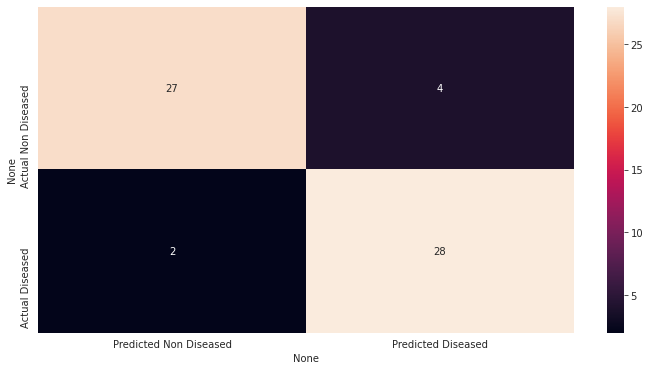

In [14]:
plt.figure(figsize=(12, 6))
pred = model.predict(x_test_scaled)
conf_df = pd.DataFrame(data=confusion_matrix(pred, y_test),
                   columns = [['Predicted Non Diseased', 'Predicted Diseased']],
                   index = [['Actual Non Diseased', 'Actual Diseased']]
                   )
sns.heatmap(conf_df, annot=True)
plt.show()

In [15]:
print('Train Score:', model.score(x_train_scaled, y_train))
print('Test Score:', model.score(x_test_scaled, y_test))
print('Recall Score:', recall_score(y_test, model.predict(x_test_scaled)))
print('Precision Score:', precision_score(y_test, model.predict(x_test_scaled)))
print('AUC Score:', roc_auc_score(y_test, model.predict(x_test_scaled)))
print('F1 Score:', f1_score(y_test, model.predict(x_test_scaled)), '\n')

4/4 [==============================] - 0s 1ms/step - loss: 0.2677 - acc: 0.8843
Train Score: 0.8842975497245789
1/1 [==============================] - 0s 867us/step - loss: 0.3064 - acc: 0.9016
Test Score: 0.9016393423080444
Recall Score: 0.875
Precision Score: 0.9333333333333333
AUC Score: 0.9030172413793103
F1 Score: 0.9032258064516129 



In [16]:
def model_for_decision_boundary(lr, neurons):
    model=Sequential()
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
    return model
model_pca = KerasClassifier(build_fn=model_for_decision_boundary, epochs=50, lr=0.001, batch_size=64, neurons=128)
model_pca.fit(x_pca, y)

Epoch 1/50
5/5 [==============================] - 0s 2ms/step - loss: 0.7679 - acc: 0.2607
Epoch 2/50
5/5 [==============================] - 0s 2ms/step - loss: 0.7209 - acc: 0.4356
Epoch 3/50
5/5 [==============================] - 0s 2ms/step - loss: 0.6817 - acc: 0.6073
Epoch 4/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6462 - acc: 0.6865
Epoch 5/50
5/5 [==============================] - 0s 1ms/step - loss: 0.6134 - acc: 0.7756
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5854 - acc: 0.7855
Epoch 7/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5603 - acc: 0.7855
Epoch 8/50
5/5 [==============================] - 0s 1ms/step - loss: 0.5398 - acc: 0.7954
Epoch 9/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5217 - acc: 0.7987
Epoch 10/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5055 - acc: 0.7987
Epoch 11/50
5/5 [==============================] - 0s 1ms/step - loss: 0.4915 - acc: 0.79

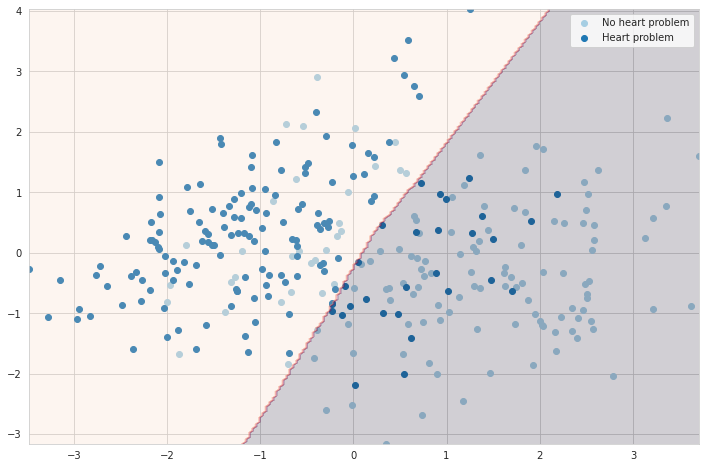

In [18]:
plt.figure(figsize=(12,8))
resolution = 200# 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(x_pca[:,0]), np.max(x_pca[:,0])
X2d_ymin, X2d_ymax = np.min(x_pca[:,1]), np.max(x_pca[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))
zz = model_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape((resolution, resolution))
plt.scatter(df_pca_no_heart_problem.iloc[:, 0], df_pca_no_heart_problem.iloc[:, 1], label='No heart problem')
plt.scatter(df_pca_heart_problem.iloc[:, 0], df_pca_heart_problem.iloc[:, 1], label='Heart problem')
plt.legend()
plt.contourf(xx, yy, zz, alpha=0.2)
plt.show()